In [1]:
import numpy as np 
import yfinance as yf
import pandas as pd
import warnings
import glob
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from arch import arch_model
import matplotlib.gridspec as gridspec
from functools import reduce
from pandas.tseries.offsets import MonthEnd


In [2]:
def CAGR(index):
    CAGR = (1+index.pct_change(len(index)-1).iloc[-1])**(1/(len(index)/FreqN))-1
    return CAGR

def Annualized(index,y):
    Annualized = (1+index.pct_change(y*FreqN).iloc[-1])**(1/(y*FreqN/FreqN))-1
    return Annualized

def Ratio(index,benchmark):
    Ratio = ((index.pct_change(1).mean()*FreqN)-(benchmark/FreqN)) / (index.pct_change(1).std() * np.sqrt(FreqN))
    return Ratio

def max_drawdown(index):
    cumulative_returns = (1 + index.pct_change()).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / rolling_max - 1
    return drawdown.min()

def value_at_risk(index, confidence_level=0.95):
    return -np.percentile(index.pct_change().dropna(), 100 - (confidence_level * 100))

def Quintiles(index,Q):
    Quintiles_mean = index.pct_change().groupby(pd.qcut(index.pct_change(), Q, labels=False)).mean()
    Quintiles_std = index.pct_change().groupby(pd.qcut(index.pct_change(), Q, labels=False)).std()*np.sqrt(12)    
    return Quintiles_mean, Quintiles_std  

def take_max(s1, s2):
    return s1.where(s1 > s2, s2)

In [3]:
startdate='2004-1-1'
enddate='2024-1-14'
listETFs=['VV','IJH','IJR','QQQ','EFV','EFA','EEM','INDA','EWJ','EWW','RWR','GC=F','DBC','VAW','XLE','AGG','TIP','HYG','TLT','SHY']
listNames=['USLargeCap','USMidCap','USSmallCap','Nasdaq','EAFE Value','EAFE','EM','India','Japan','Mexico','REITs','Gold','Commodities','Materials','Energy','USBonds','TIPs','HighYields','LongBonds','Cash']
listAssetClass=['Equity','Equity','Equity','Equity','Equity','Equity','Equity','Equity','Equity','Equity','Real Estate','Commodity','Commodity','Commodity','Commodity','Bonds','Bonds','Bonds','Bonds','Cash']

initial_value = 100
SPXAGG=yf.download(tickers=['SPY','AGG'], start=startdate, end=enddate)['Adj Close']
SPXAGGReturns=SPXAGG.pct_change()
SPXAGGReturns['SPXAGG']=0.6*SPXAGGReturns['SPY']+0.4*SPXAGGReturns['AGG']
SPXAGGReturns=SPXAGGReturns.iloc[:,-1]
initial_value = 100
index_6040_raw = (1 + SPXAGGReturns).cumprod() * initial_value
index_6040_raw.iloc[0] = initial_value
Names=pd.DataFrame(listNames,index=listETFs,columns=['Name'])
High=yf.download(tickers=listETFs, start=startdate, end=enddate)['High']
High=Names.merge(High.T,right_index=True,left_index=True).set_index('Name').T
Low=yf.download(tickers=listETFs, start=startdate, end=enddate)['Low']
Low=Names.merge(Low.T,right_index=True,left_index=True).set_index('Name').T
Close=yf.download(tickers=listETFs, start=startdate, end=enddate)['Close']
Close=Names.merge(Close.T,right_index=True,left_index=True).set_index('Name').T
AdjClose=yf.download(tickers=listETFs, start=startdate, end=enddate)['Adj Close']
AdjClose=Names.merge(AdjClose.T,right_index=True,left_index=True).set_index('Name').T
for i in [High,Low,Close,AdjClose]:
    i.index=pd.DatetimeIndex(i.index)

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  20 of 20 completed


In [4]:
#Model_Momentum

# Calculate percentage returns and drop NaN values
M=(AdjClose.pct_change(80) * 100).dropna(how='all')
ModelMomentum = M.rank(axis=1,ascending=True)

#Model_Correlation

# Calculate percentage returns and drop NaN values
Returns = (Close.pct_change(1) * 100).dropna(how='all')

# Step 1: Calculate the average daily return across all asset classes
average_daily_returns = Returns.mean(axis=1)

# Step 2: Create a new DataFrame to store the correlations
correlation_df = pd.DataFrame(index=Returns.index)

# Calculate the correlation for each asset class
for asset in Returns.columns:
    correlation_df[asset] = Returns[asset].rolling(window=80).corr(average_daily_returns)

ModelCorrelation=correlation_df.rank(axis=1,ascending=False)

#Model_Volatility

# Calculate percentage returns and drop NaN values
Returns = (Close.pct_change() * 100).dropna(how='all').fillna(0)

# Initialize dictionaries to store models and results
models = {}
results = {}
volatility = {}

# Create and fit the models, then store the results and volatilities
for name in listNames:
    models[name] = arch_model(Returns[name], vol='Garch', p=1, q=1)
    results[name] = models[name].fit(update_freq=10, disp='off')
    volatility[name] = results[name].conditional_volatility

# Create a DataFrame to store the volatility data
ModelVolatility = pd.DataFrame(volatility).rank(axis=1,ascending=False)

# Calculate the absolute value of High minus previous Close
high_minus_close = abs(High- Close.shift(1))

# Calculate the absolute value of Low minus previous Close
low_minus_close = abs(Low - Close.shift(1))

# Calculate High minus Low
high_minus_low = High - Low



max_df_12 = high_minus_close.combine(low_minus_close, take_max)
TRs = max_df_12.combine(high_minus_low, take_max)
Trs42=TRs.rolling(window=42).sum().div(42)
Upper_Band=(Close.rolling(window=63).max().shift(1)+Trs42)
Lower_Band=(Low.rolling(window=105).min().shift(1)+Trs42)

conditions = [
    (Close >= Upper_Band),
    (Low < Lower_Band)
]

# Define the choices based on conditions
choices = [2,-2]

ATRsignals= pd.DataFrame(np.select(conditions, choices, default=0), index=High.index, columns=High.columns)
for column in ATRsignals.columns:
    prev_score = 0  # Keep track of previous score
    
    for idx in range(len(ATRsignals[column])):
        current_score = ATRsignals[column].iloc[idx]
        
        # Check if the current score is 0 or same as previous, then use the previous score
        if current_score == 0 or current_score == prev_score:
            ATRsignals[column].iloc[idx] = prev_score
        else:  # If it's a new score (opposite), update the previous score tracker
            prev_score = current_score

/Users/benjaminlee/.virtualenvs/quant/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [5]:
# Create Portfolio
Freq='M'
FreqN=12
n=4
wM=0.7
wV=(0.1)
Wc=(0.1)
Wt=(0.1)
stopLoss_threshold=-0.035
x=100
Total=(wM*ModelMomentum+wV*ModelVolatility+Wc*ModelCorrelation+Wt*ATRsignals)+M.div(x)
TotalRank=Total.iloc[:,:-1].rank(axis=1,ascending=False)
conditions = [
    (TotalRank <= n) & (M.iloc[:,:-1] > 3) & (ATRsignals.iloc[:,:-1] > 0)
]

# Define the choices based on conditions
choices = [1/n]

Weights= pd.DataFrame(np.select(conditions, choices, default=0), index=TotalRank.index, columns=TotalRank.columns)
Weights['Cash']=1-Weights.sum(axis=1)
Weights_resampled=Weights.groupby([Weights.index.year, Weights.index.month]).tail(1)
weight_df=pd.DataFrame(np.nan,index=Weights.index,columns=Weights.columns).loc[Weights_resampled.index[0]:]
weight_df.loc[Weights_resampled.index]=Weights_resampled
weight_df=weight_df.fillna(method='ffill')
not_in_weights_resampled = ~weight_df.index.isin(Weights_resampled.index)
# Initialize a DataFrame to hold the intramonth performance
IntramonthPerformance = pd.DataFrame(index=AdjClose.index, columns=AdjClose.columns)

# Loop through each month
for year in AdjClose.index.year.unique():
    for month in AdjClose.index.month.unique():
        # Filter data for the specific month and year
        monthly_data = AdjClose[(AdjClose.index.year == year) & (AdjClose.index.month == month)]
        
        if not monthly_data.empty:
            # Identify the last trading day of the previous month
            if month == 1:
                prev_month_data = AdjClose[(AdjClose.index.year == year - 1) & (AdjClose.index.month == 12)]
            else:
                prev_month_data = AdjClose[(AdjClose.index.year == year) & (AdjClose.index.month == month - 1)]

            if not prev_month_data.empty:
                last_day_prev_month = prev_month_data.index[-1]
                last_day_prev_month_price = AdjClose.loc[last_day_prev_month]
            else:
                # Handle case where there's no data for the previous month
                continue

            # Calculate performance relative to the last trading day of the previous month
            for day in monthly_data.index:
                IntramonthPerformance.loc[day] = AdjClose.loc[day].div(last_day_prev_month_price) - 1


# Convert performance to numeric values
IntramonthPerformance = IntramonthPerformance.apply(pd.to_numeric).fillna(0).loc[weight_df.index]
IntramonthPerformance.loc[Weights_resampled.index]=0
weight_df=(weight_df*(IntramonthPerformance+1))
weight_df=weight_df.div(weight_df.sum(axis=1).to_frame()[0],axis=0)
IntramonthPerformance=IntramonthPerformance.shift(-1)
IntramonthPerformance.loc[Weights_resampled.index]=0

# Loop through each row in the performance DataFrame
for index, row in IntramonthPerformance.iterrows():
    # Find the last day of the current month
    last_day_of_month = index + MonthEnd(0)

    # Check if any asset's performance is less than -0.05
    for column in IntramonthPerformance.columns:
        if row[column] < stopLoss_threshold:
            # Set the weight to 0 from this day to the end of the month for this asset
            weight_df.loc[index:last_day_of_month, column] = 0

weight_df.loc[Weights_resampled.iloc[:-1].index]=Weights_resampled.iloc[:-1]

results_long_df=weight_df.mul(AdjClose.pct_change().shift(-1)).sum(axis=1)
index_long = ((1 + results_long_df).cumprod() * initial_value).resample(Freq).last()
results_long_df=index_long.pct_change()
turnover_long=weight_df.iloc[:,:-1][weight_df.iloc[:,:-1].diff().abs()>0.1].sum(axis=1).groupby([weight_df.index.year, weight_df.index.month]).sum().reset_index()[0].rolling(window=12).sum()
turnover_long.index=weight_df.resample('M').last().index

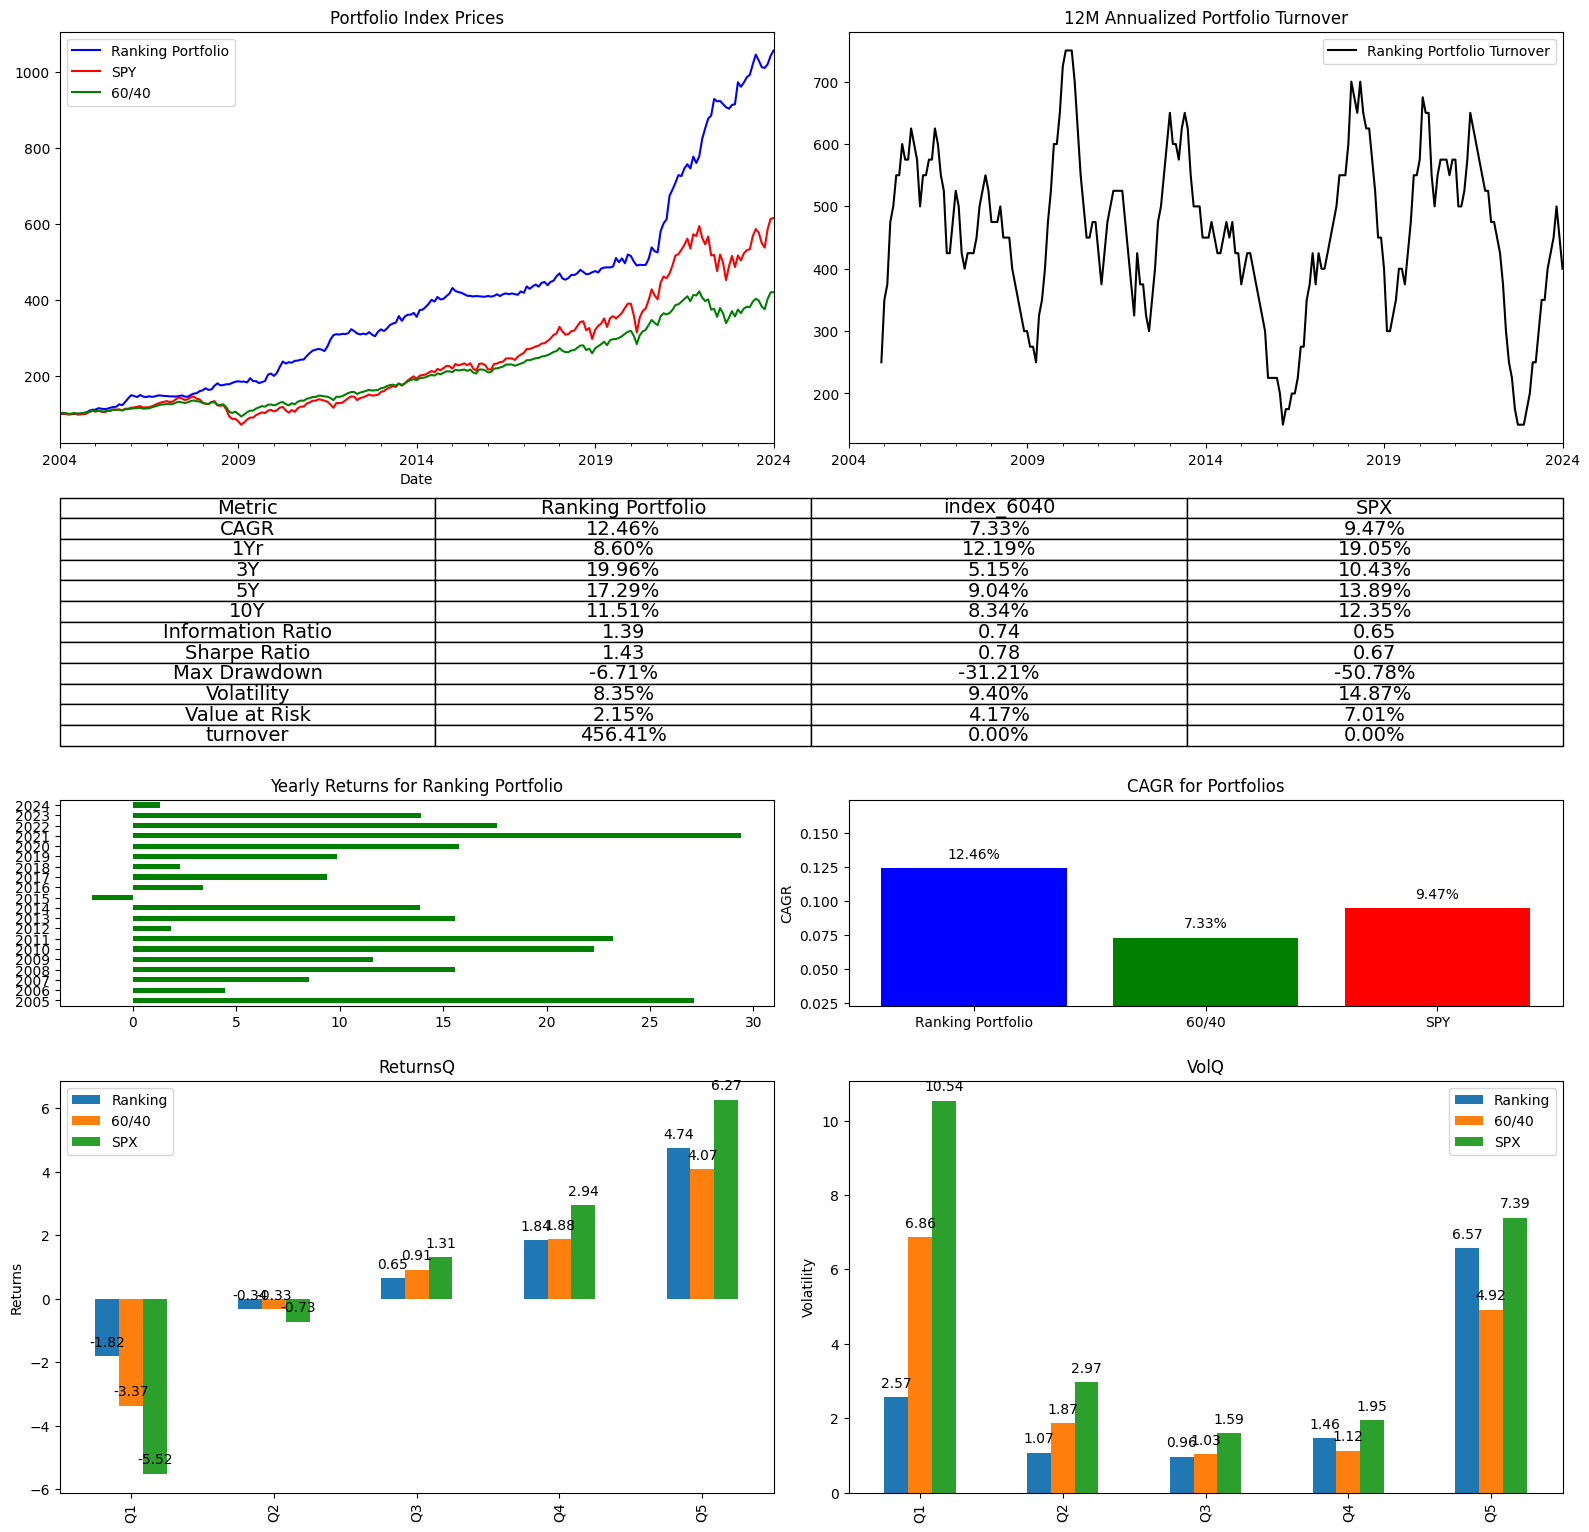

In [6]:
index_6040 = index_6040_raw.copy().resample('M').last()
SPX = SPXAGG['SPY'].copy().resample('M').last()

def volatility(index):
    return index.pct_change().std() * np.sqrt(12)

stats_data = {
    'Metric': ['CAGR','1Yr','3Y','5Y','10Y', 'Information Ratio','Sharpe Ratio', 'Max Drawdown', 'Volatility', 'Value at Risk','turnover'],
    'Ranking Portfolio': [CAGR(index_long),Annualized(index_long,1),
                          Annualized(index_long,3),Annualized(index_long,5),
                          Annualized(index_long,10),Ratio(index_long,0.07),
                          Ratio(index_long,0.03), max_drawdown(index_long),
                          volatility(index_long), value_at_risk(index_long),turnover_long.mean()],
    'index_6040': [CAGR(index_6040),Annualized(index_6040,1),
                          Annualized(index_6040,3),Annualized(index_6040,5),
                          Annualized(index_6040,10),Ratio(index_6040,0.07),
                          Ratio(index_6040,0.03), max_drawdown(index_6040),
                          volatility(index_6040), value_at_risk(index_6040),0],
    'SPX': [CAGR(SPX),Annualized(SPX,1),
                          Annualized(SPX,3),Annualized(SPX,5),
                          Annualized(SPX,10),Ratio(SPX,0.07),
                          Ratio(SPX,0.03), max_drawdown(SPX),
                          volatility(SPX), value_at_risk(SPX),0]

}
stats_df = pd.DataFrame(stats_data)

ReturnsQ=pd.DataFrame((Quintiles(index_long,5)[0],Quintiles(index_6040,5)[0],Quintiles(SPX,5)[0]),index=['Ranking','60/40','SPX']).round(4).T*100
VolQ=pd.DataFrame((Quintiles(index_long,5)[1],Quintiles(index_6040,5)[1],Quintiles(SPX,5)[1]),index=['Ranking','60/40','SPX']).round(4).T*100

# Assuming all necessary data and functions are already defined

# Create 1-pager figure
fig = plt.figure(figsize=(16, 20))
gs = gridspec.GridSpec(5, 2, height_ratios=[2, 1, 1, 2, 2])

# Plotting returns for Long and Short Portfolios
ax0 = plt.subplot(gs[0, 0])
index_long.plot(ax=ax0, color='blue', label='Ranking Portfolio')
SPX.div(SPX.iloc[0]).mul(100).plot(ax=ax0, color='red', label='SPY')
index_6040.plot(ax=ax0, color='green', label='60/40')
ax0.set_title('Portfolio Index Prices')
ax0.legend()

# Plotting turnover for Long and Short Portfolios
ax1 = plt.subplot(gs[0, 1])
turnover_long.mul(100).plot(ax=ax1, color='black', label='Ranking Portfolio Turnover')
ax1.set_title('12M Annualized Portfolio Turnover')
ax1.legend()

# Adding the table
ax2 = plt.subplot(gs[1, :])
ax2.axis('off')
table_data = []
columns = ['Metric', 'Ranking Portfolio', 'index_6040', 'SPX']
table_data.append(columns)

for i, row in enumerate(stats_df.itertuples()):
    if i in [5, 6]: 
        table_data.append([row[1], round(row[2], 2), round(row[3], 2), round(row[4], 2)])
    else:
        table_data.append([row[1], '{:.2%}'.format(row[2]), '{:.2%}'.format(row[3]), '{:.2%}'.format(row[4])])

table = ax2.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.25]*4)
table.auto_set_font_size(False)
table.set_fontsize(14)  # Set the fontsize here

# Plotting yearly returns for the Long/Short portfolio
ax3 = plt.subplot(gs[2, 0])
index_long.resample('Y').last().pct_change(1).dropna().mul(100).plot(kind='barh', ax=ax3, color='green')
ax3.set_title('Yearly Returns for Ranking Portfolio')
ax3.set_yticklabels([str(date.year) for date in index_long.resample('Y').last().pct_change(1).dropna().index])

# Plotting CAGR for all portfolios
ax4 = plt.subplot(gs[2, 1])
cagr_data = [CAGR(index_long), CAGR(index_6040), CAGR(SPX)]
portfolios = ['Ranking Portfolio', '60/40', 'SPY']
bars = ax4.bar(portfolios, cagr_data, color=['blue', 'green', 'red'])
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f'{height:.2%}', ha='center', va='bottom')
ax4.set_title('CAGR for Portfolios')
ax4.set_ylabel('CAGR')
ax4.set_ylim(min(cagr_data) - 0.05, max(cagr_data) + 0.05)

# Plotting ReturnsQ
ax5 = plt.subplot(gs[3, 0])
ReturnsQ.plot(kind='bar', ax=ax5, title='ReturnsQ')
ax5.set_ylabel('Returns')
ax5.set_xticklabels(['Q1','Q2','Q3','Q4','Q5'])

# Plotting VolQ
ax6 = plt.subplot(gs[3, 1])
VolQ.plot(kind='bar', ax=ax6, title='VolQ')
ax6.set_ylabel('Volatility')
ax6.set_xticklabels(['Q1','Q2','Q3','Q4','Q5'])

# Function to add values on top of the bars
def add_values_on_bars(axes, spacing=5):
    for ax in axes:
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, spacing), textcoords="offset points", ha='center', va='bottom')

# Add values on top of bars for both ReturnsQ and VolQ
add_values_on_bars([ax5, ax6])

plt.tight_layout()
plt.show()


In [7]:
#odds of buying and selling first month:
def apply_conditions(df):
    new_df = df.copy()
    for col in df.columns:
        for i in range(1, len(df)):
            if df[col].iloc[i] > 0:
                if df[col].iloc[i] != df[col].iloc[i-1]:
                    new_df[col].iloc[i] = 1
                else:
                    new_df[col].iloc[i] = new_df[col].iloc[i-1] + 1
            else:
                new_df[col].iloc[i] = 0
    return new_df

FrequencyTrades = apply_conditions(weight_df.resample('M').last())

def transform_df(df):
    for col in df.columns:
        count = 0
        for i in range(len(df)):
            if df[col].iloc[i] > 0:
                count += 1
                # Replace non-final values with 0
                df[col].iloc[i] = 0
            else:
                if count > 0:
                    # Set the final value before the asset is sold
                    df[col].iloc[i - 1] = count
                count = 0
    return df
transformed_df = transform_df(FrequencyTrades.copy()).replace(0, np.nan)

transformed_df[transformed_df==1].count().div(transformed_df.count())


Name
USLargeCap     0.583333
USMidCap       0.583333
USSmallCap     0.375000
Nasdaq         0.384615
EAFE Value     0.333333
EAFE           0.600000
EM             0.500000
India          0.363636
Japan          0.583333
Mexico         0.200000
REITs          0.266667
Gold           0.535714
Commodities    0.214286
Materials      0.500000
Energy         0.294118
USBonds        0.857143
TIPs           0.777778
HighYields     1.000000
LongBonds      0.333333
Cash           0.285714
dtype: float64

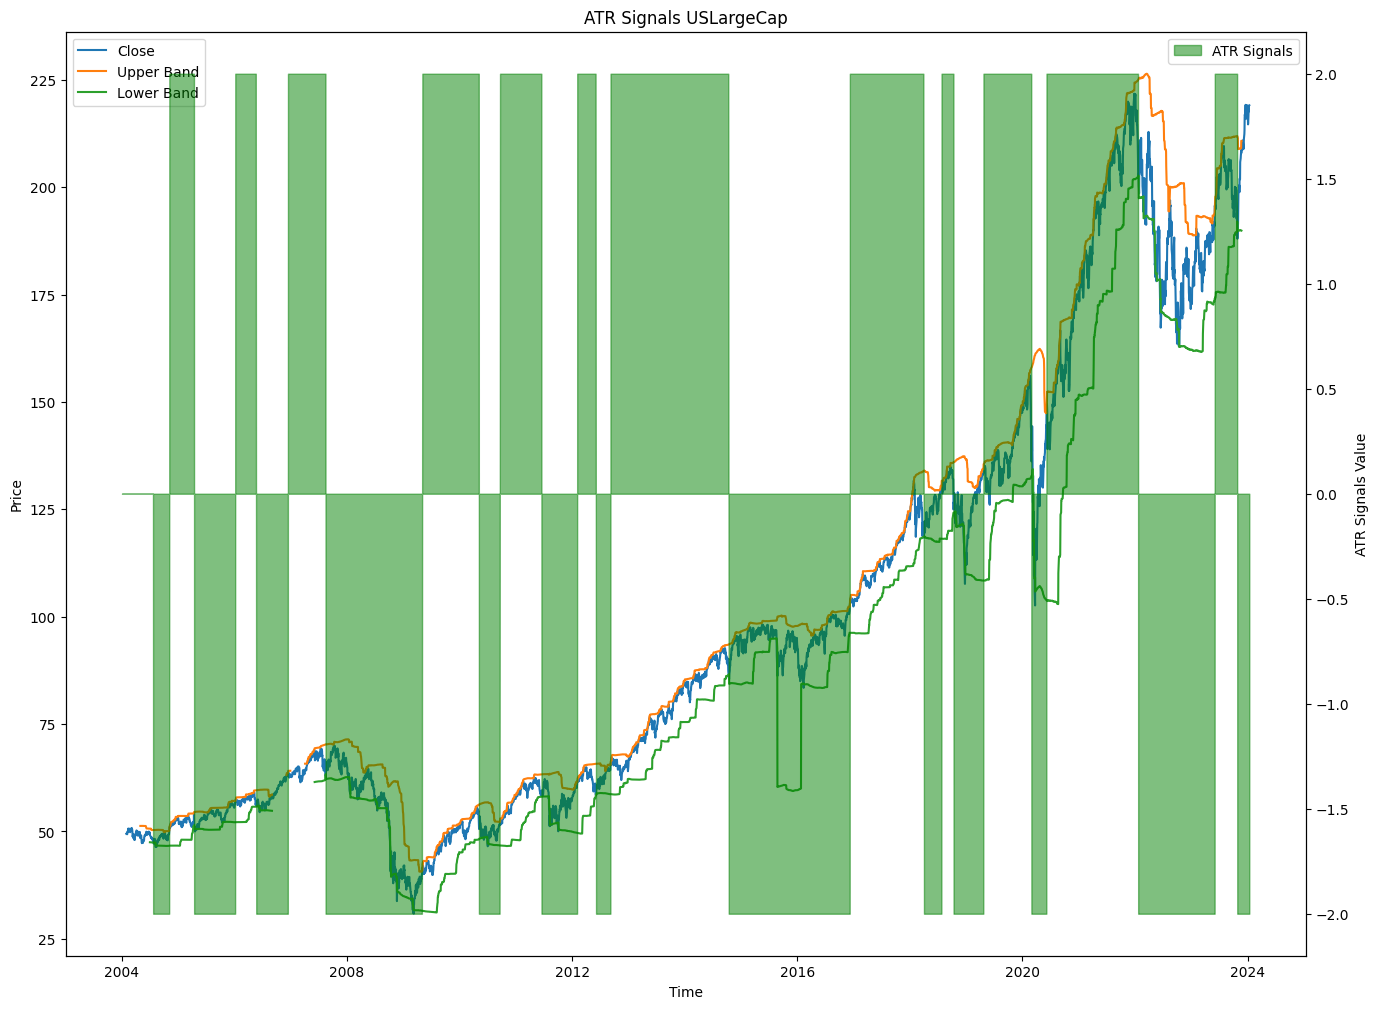

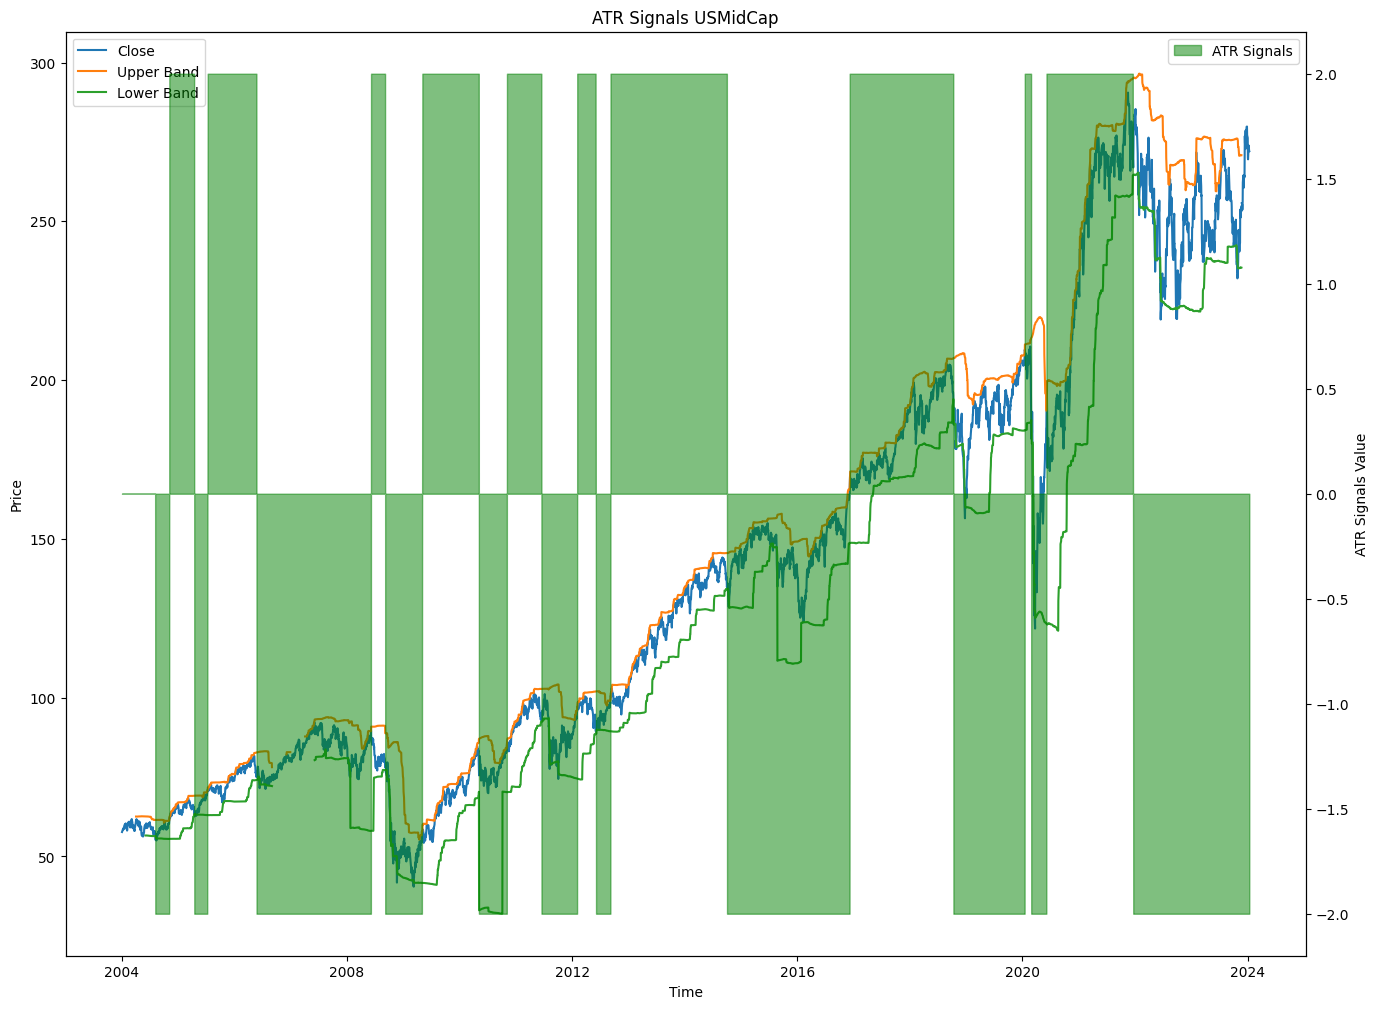

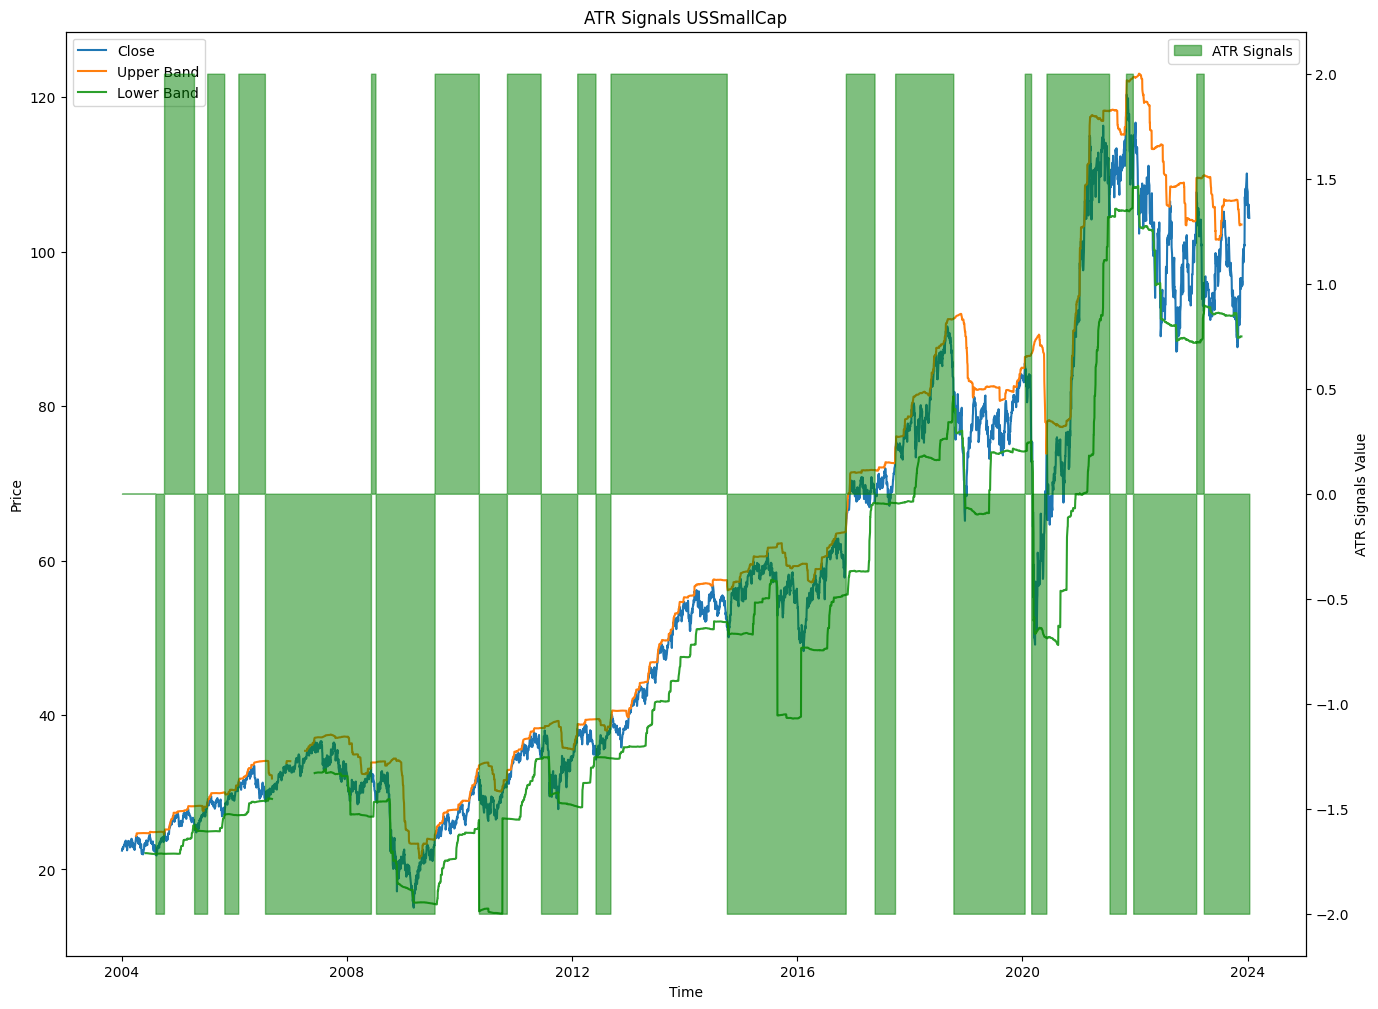

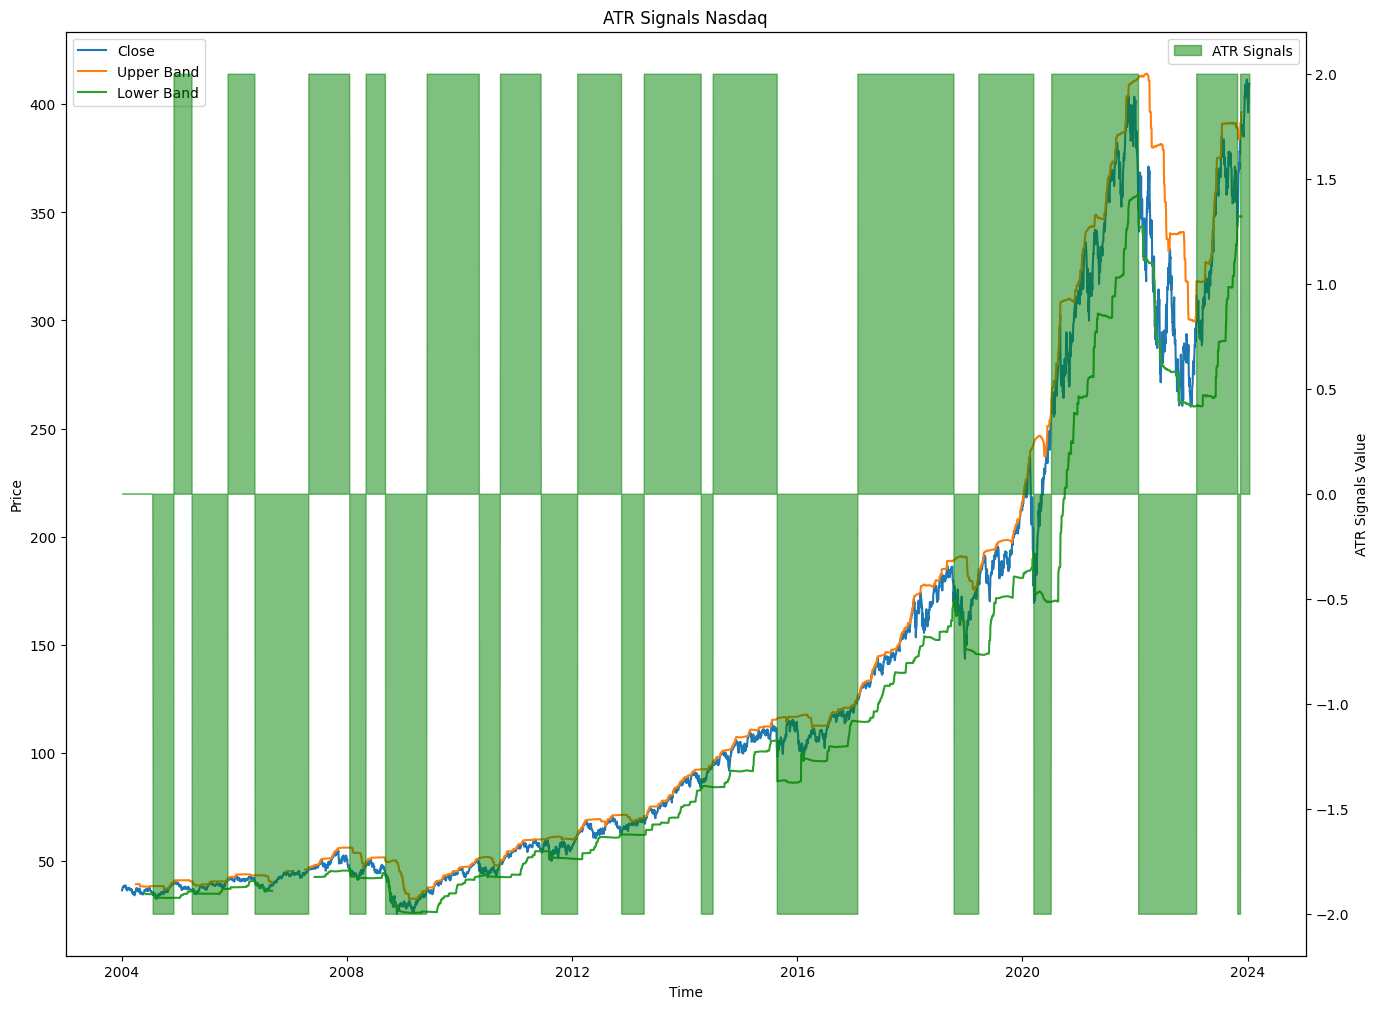

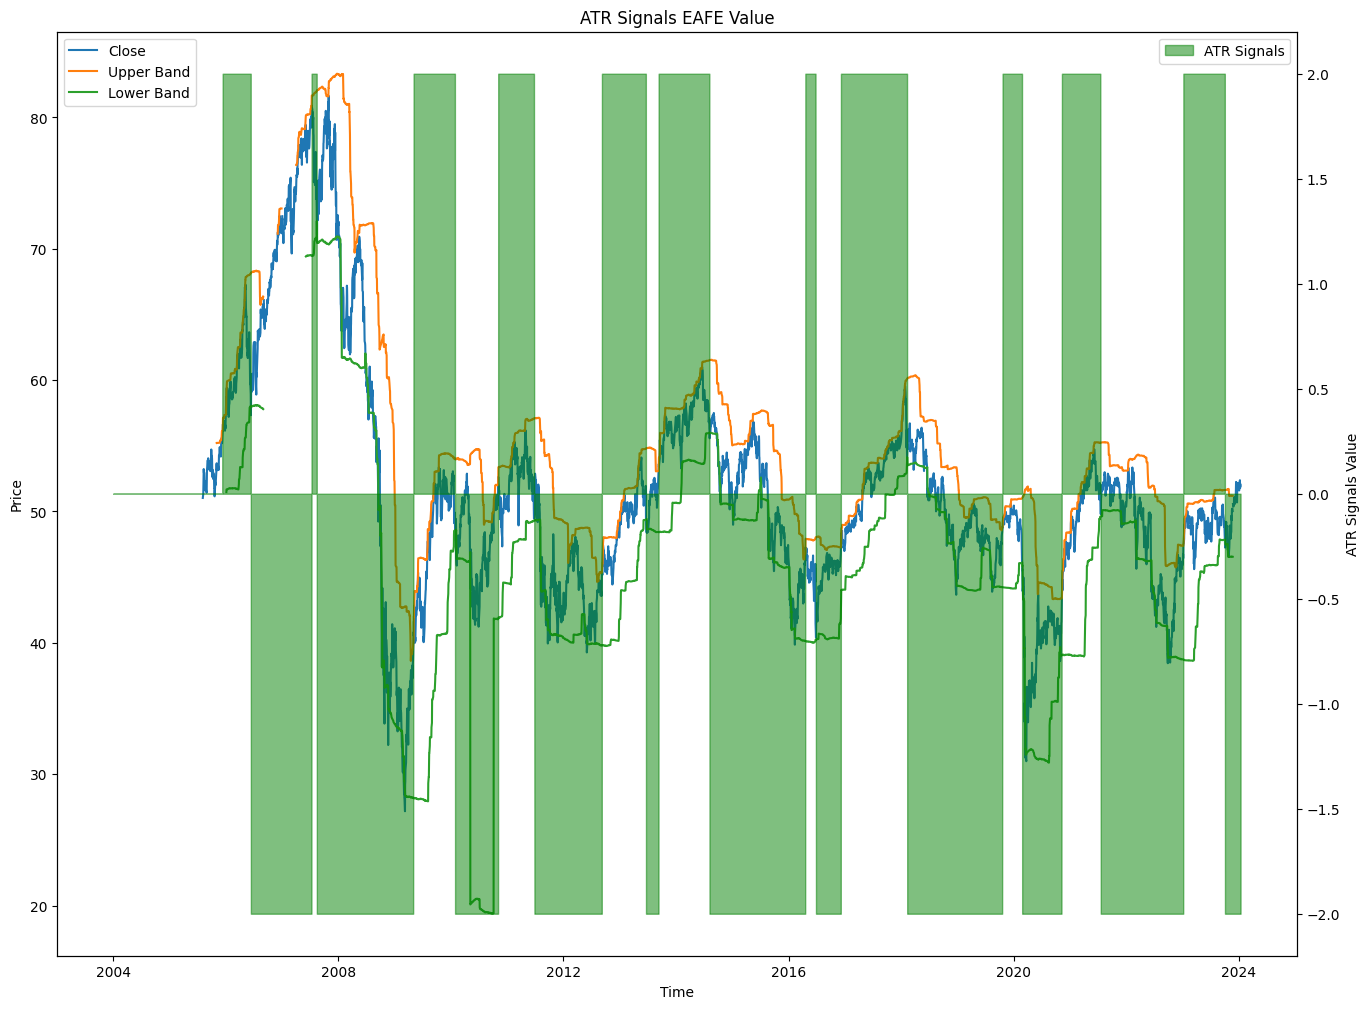

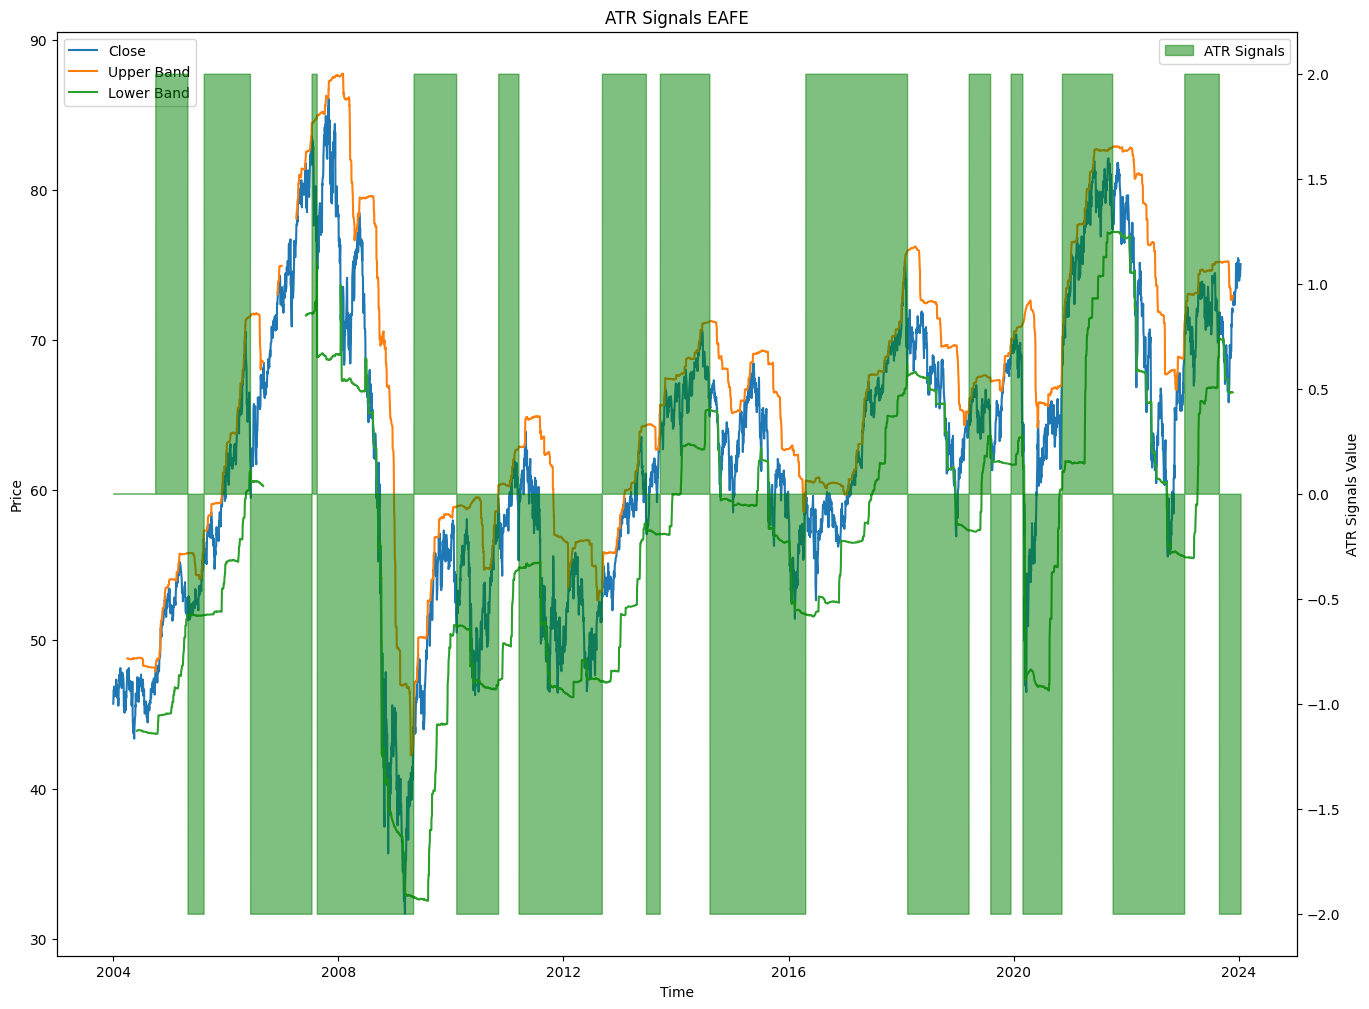

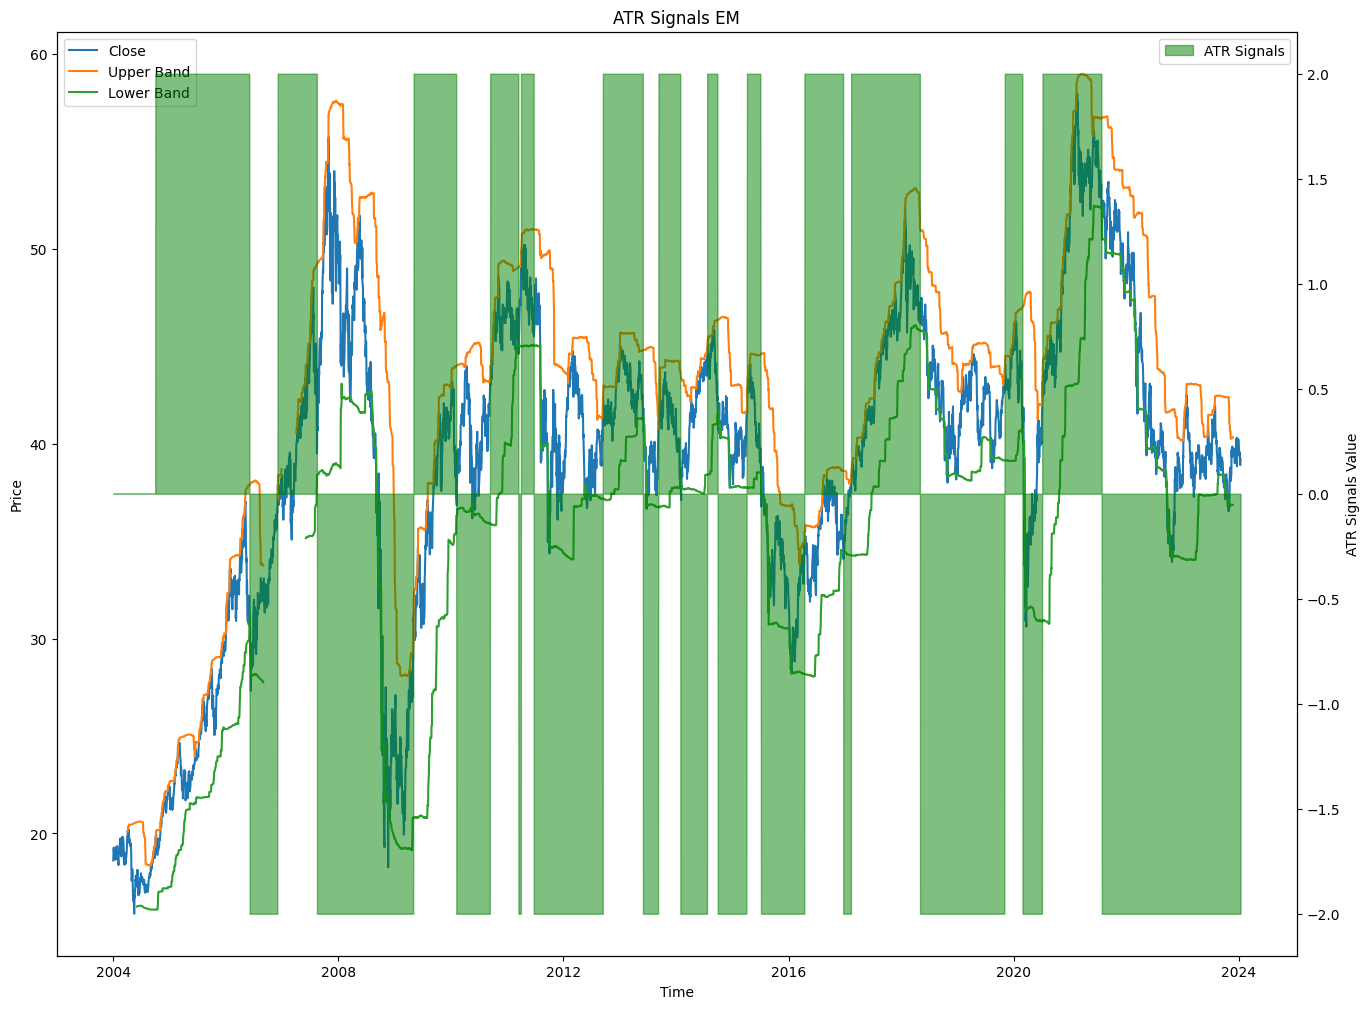

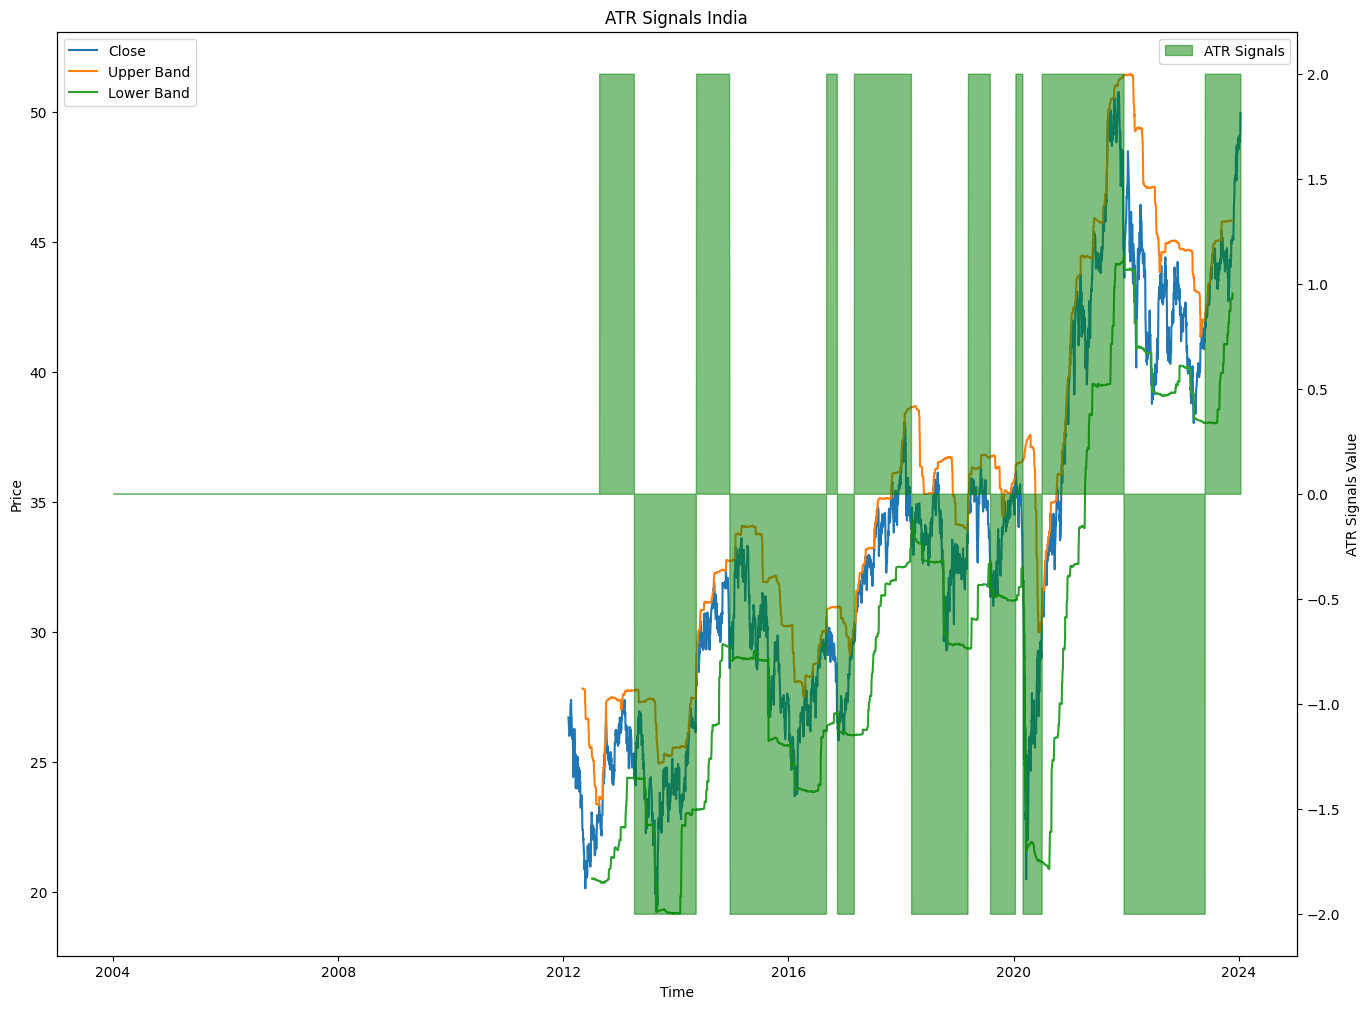

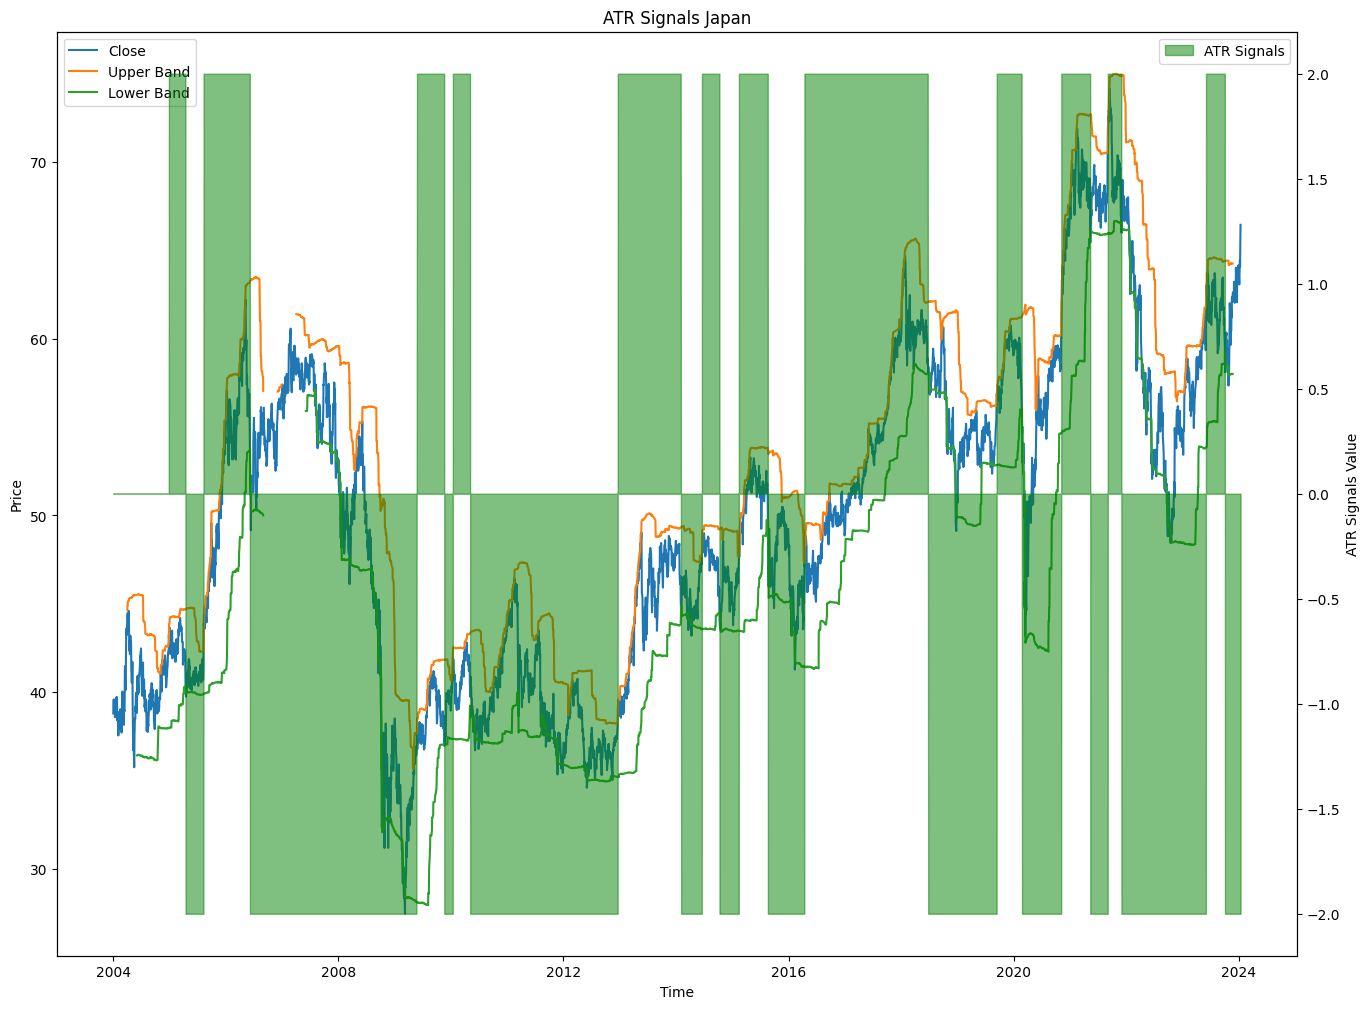

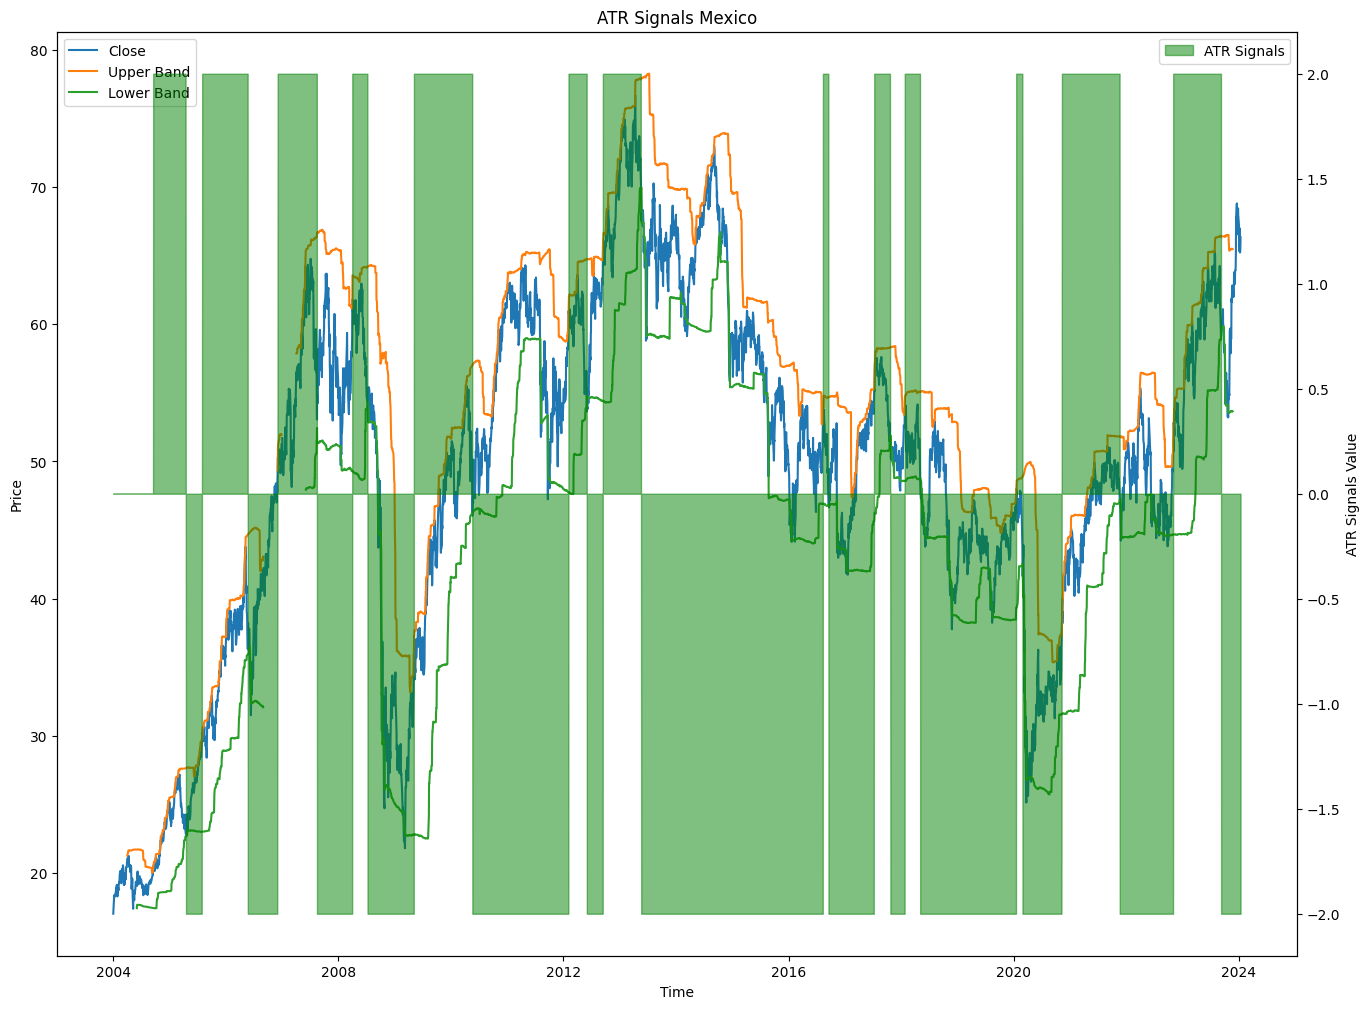

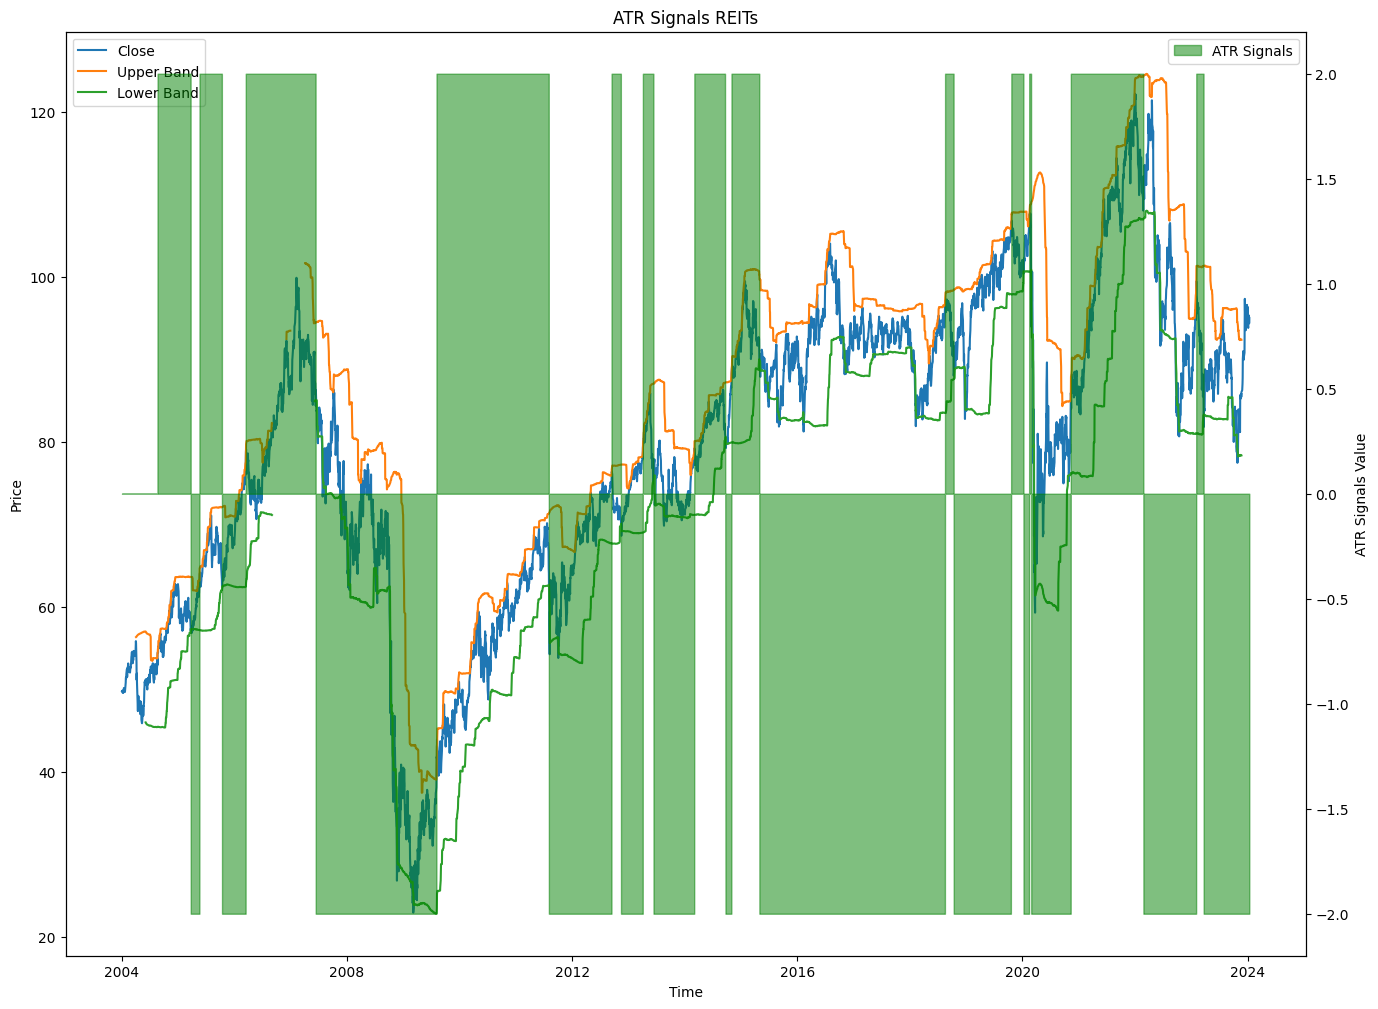

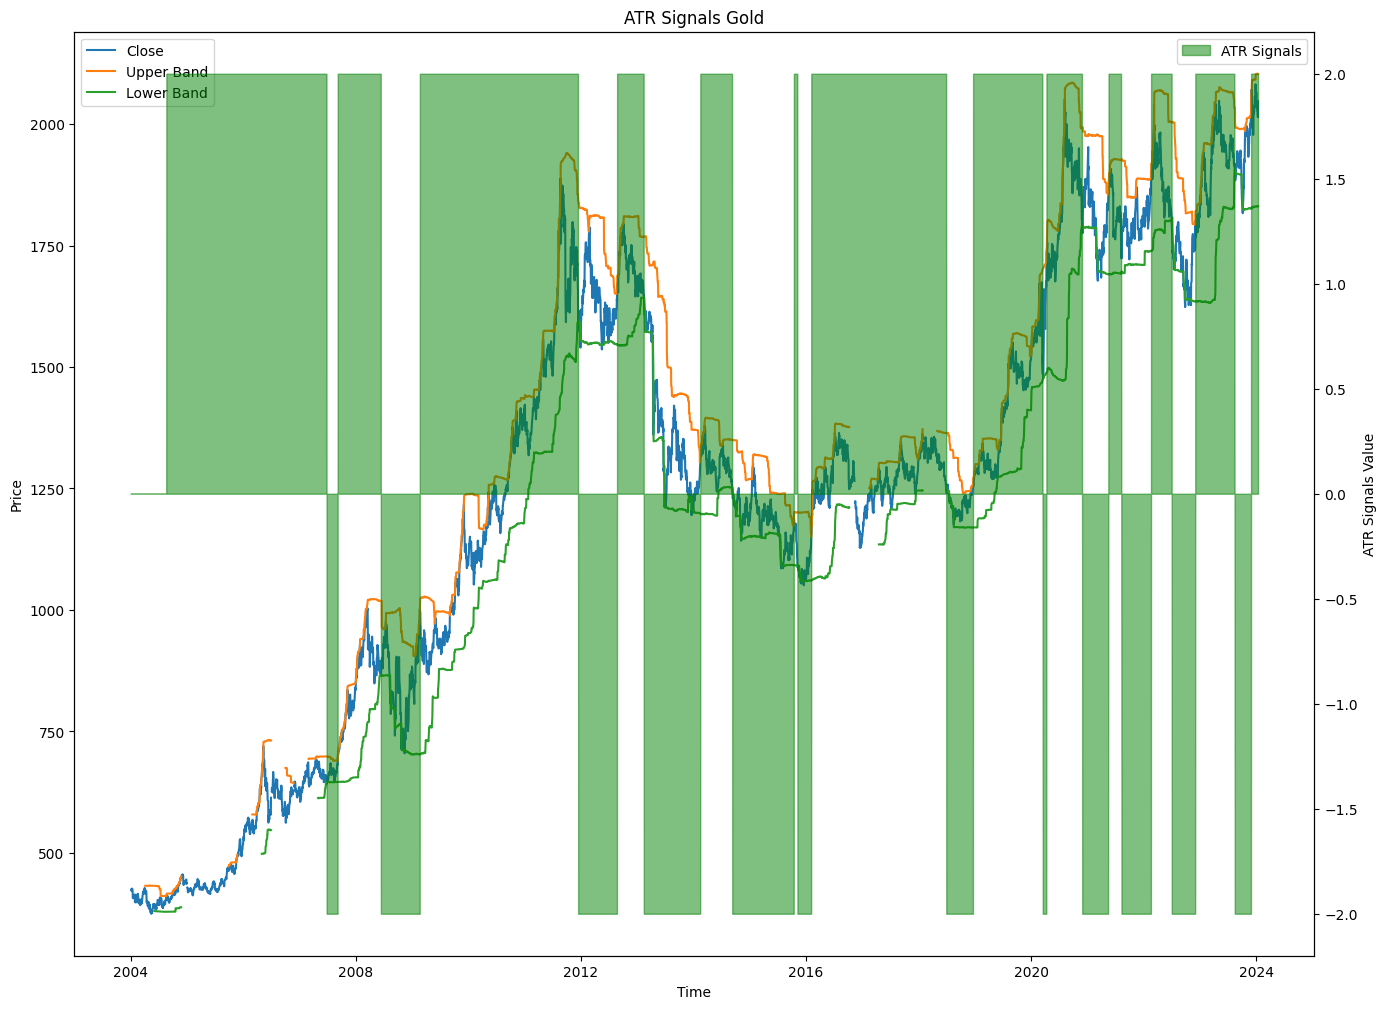

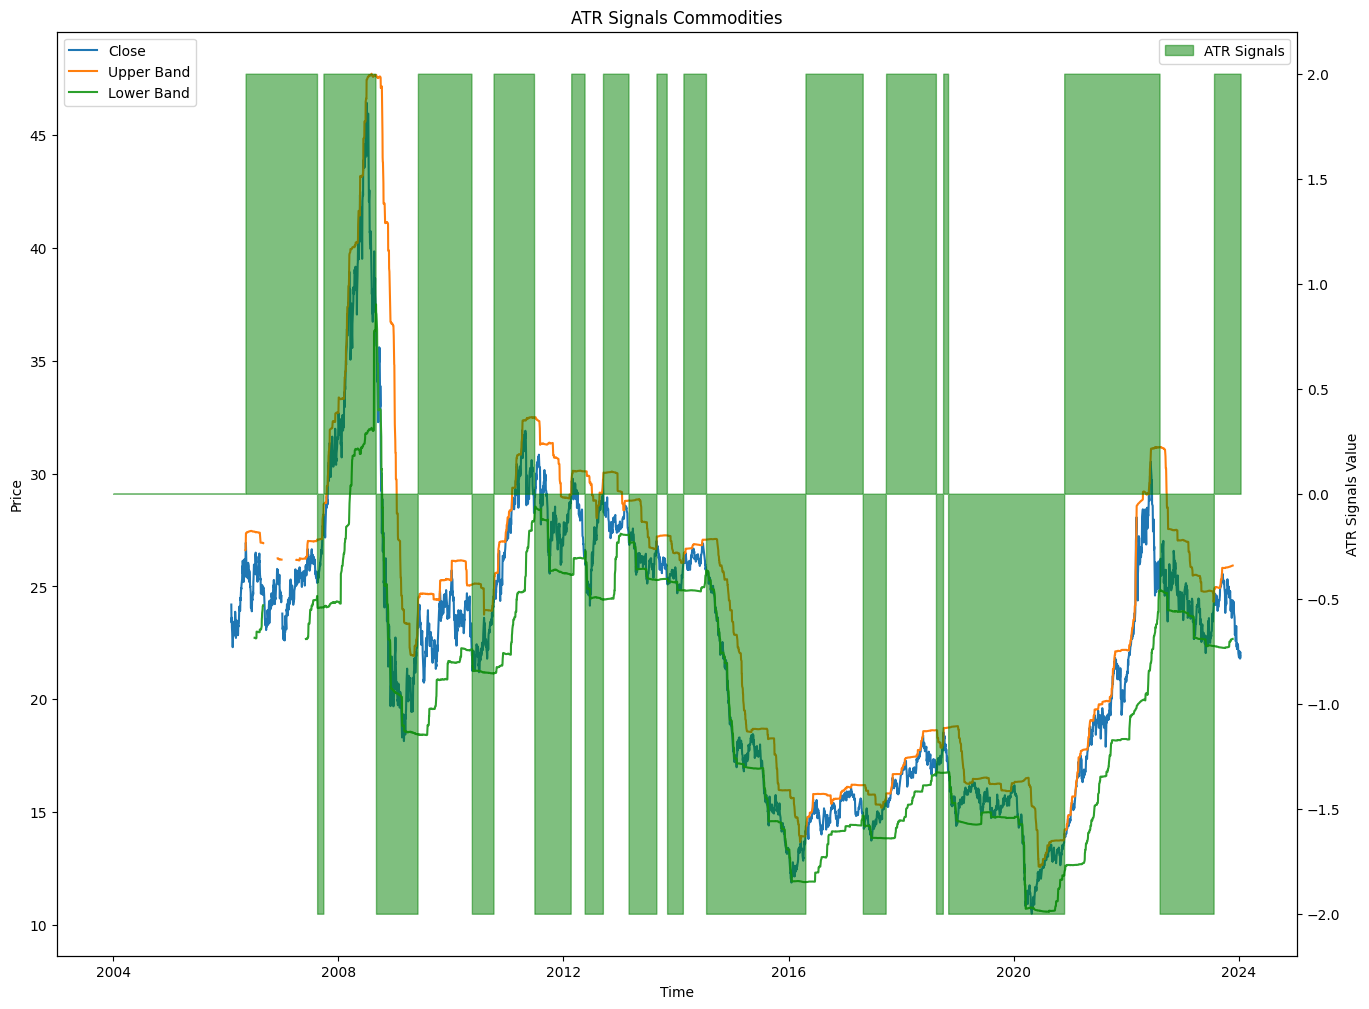

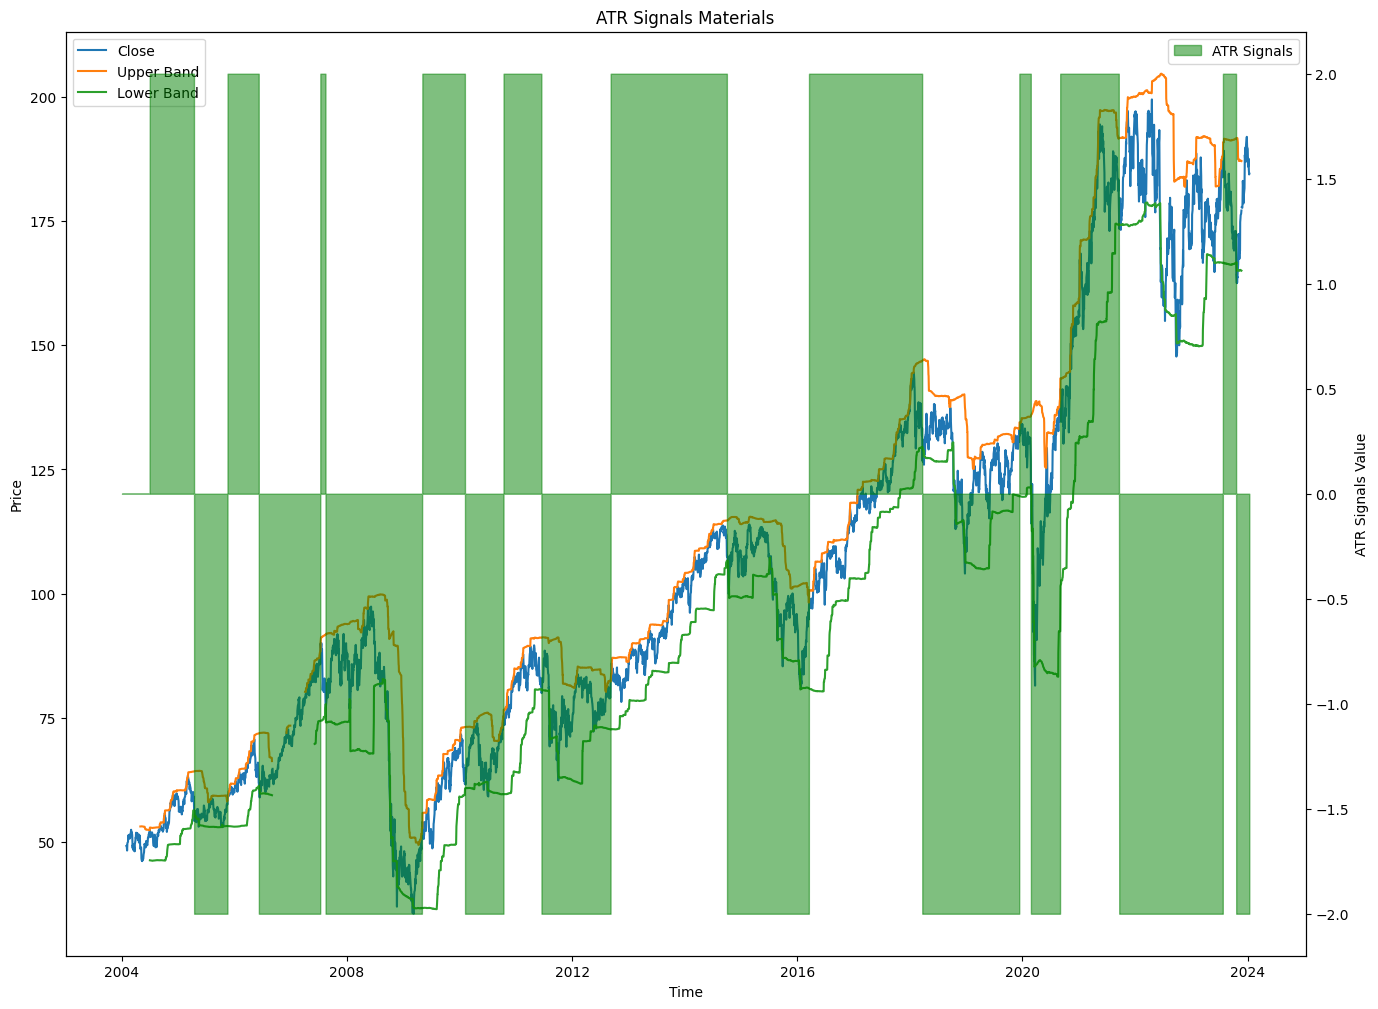

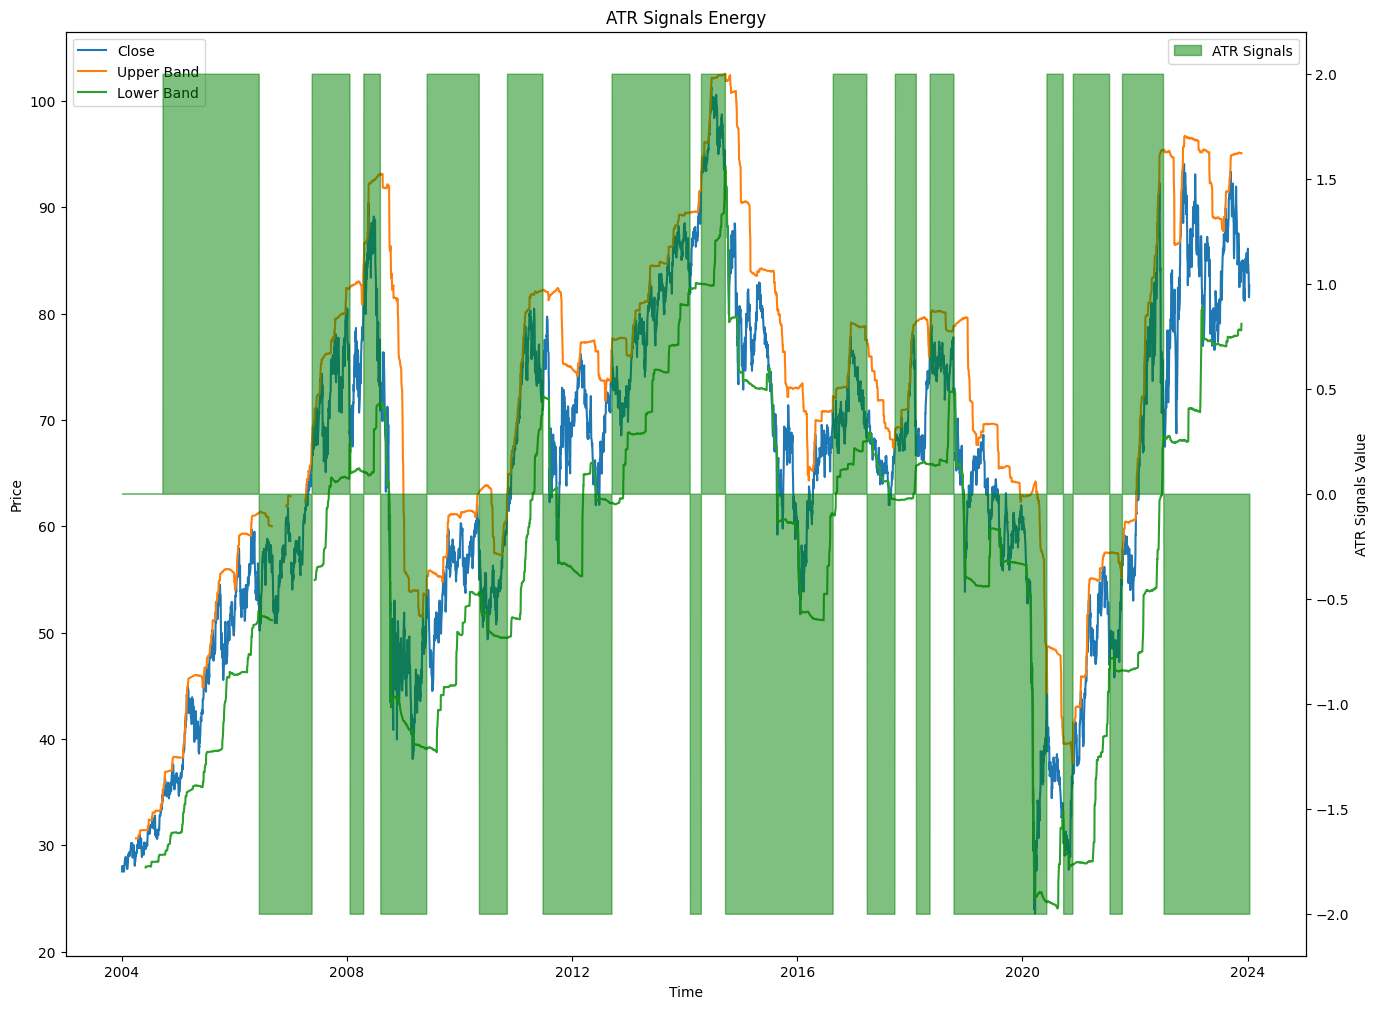

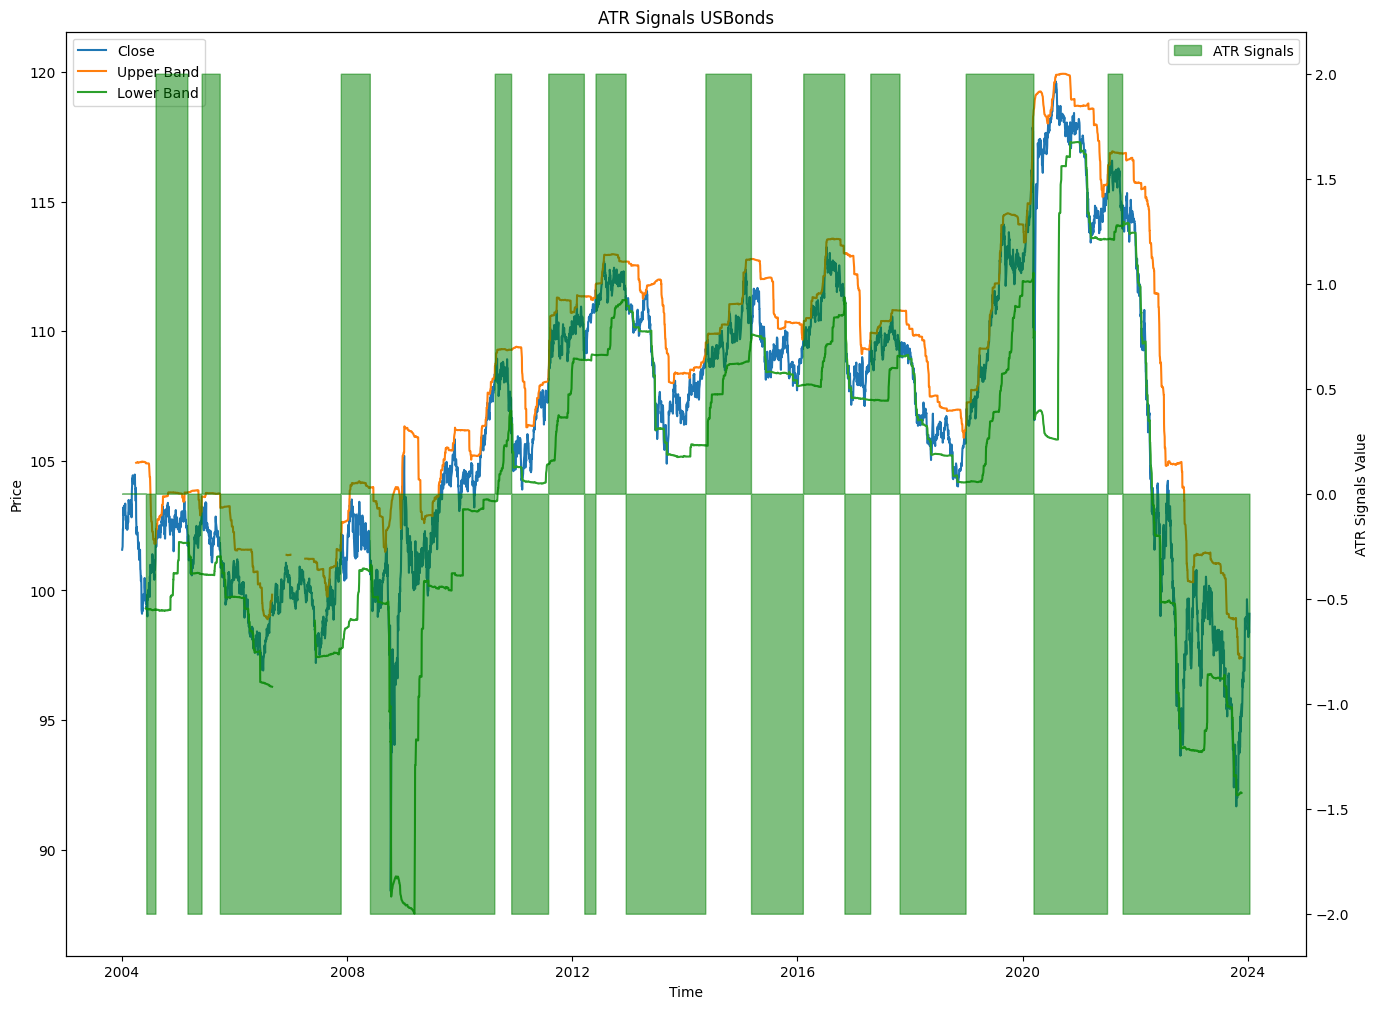

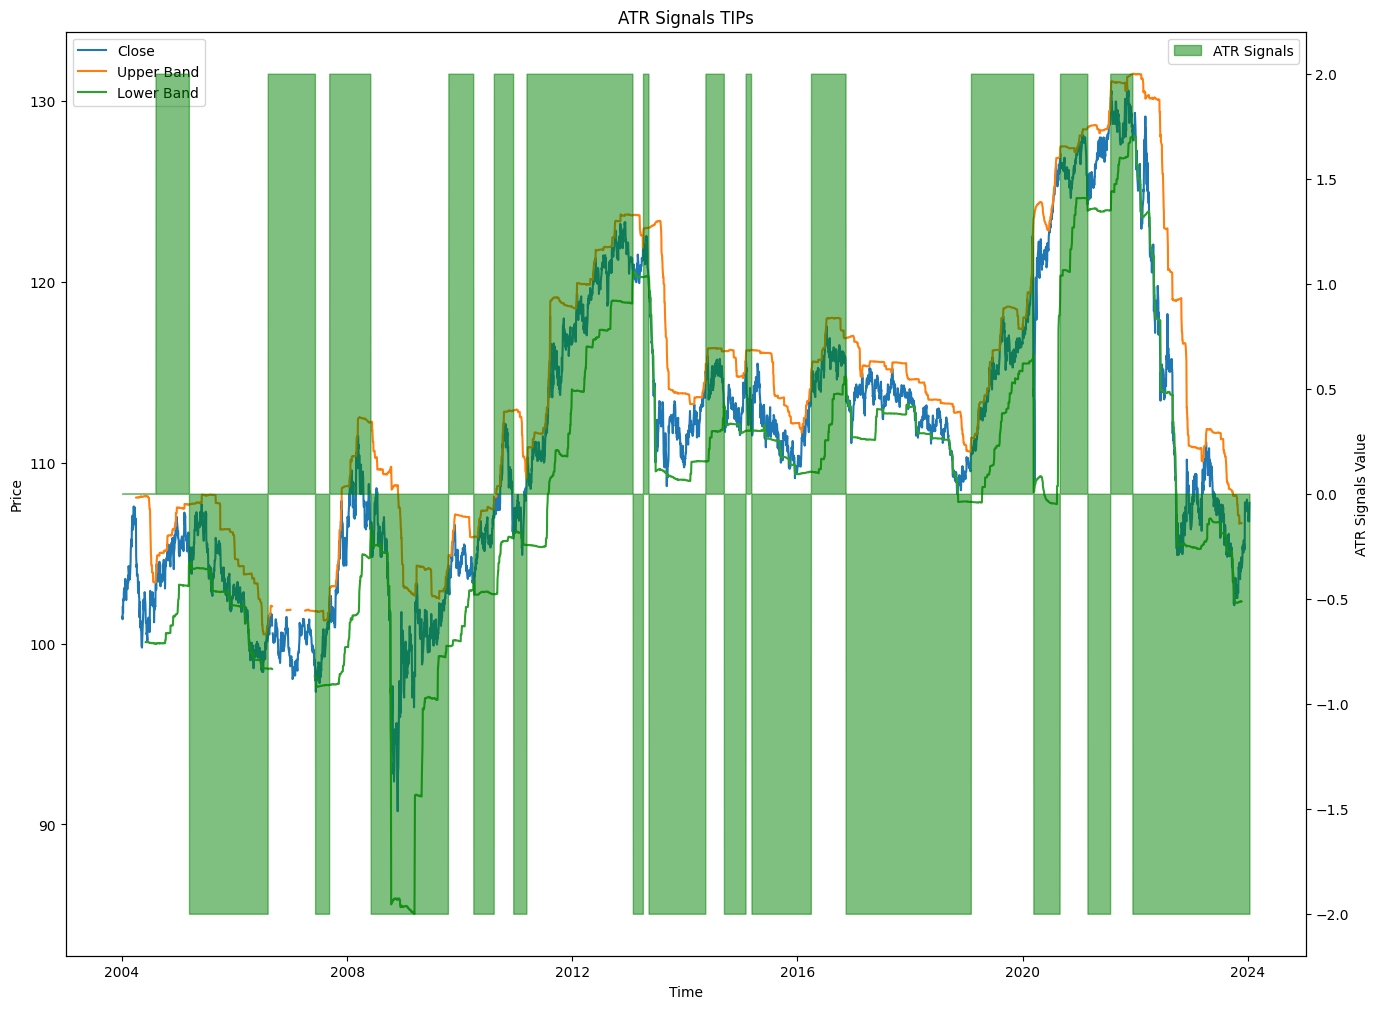

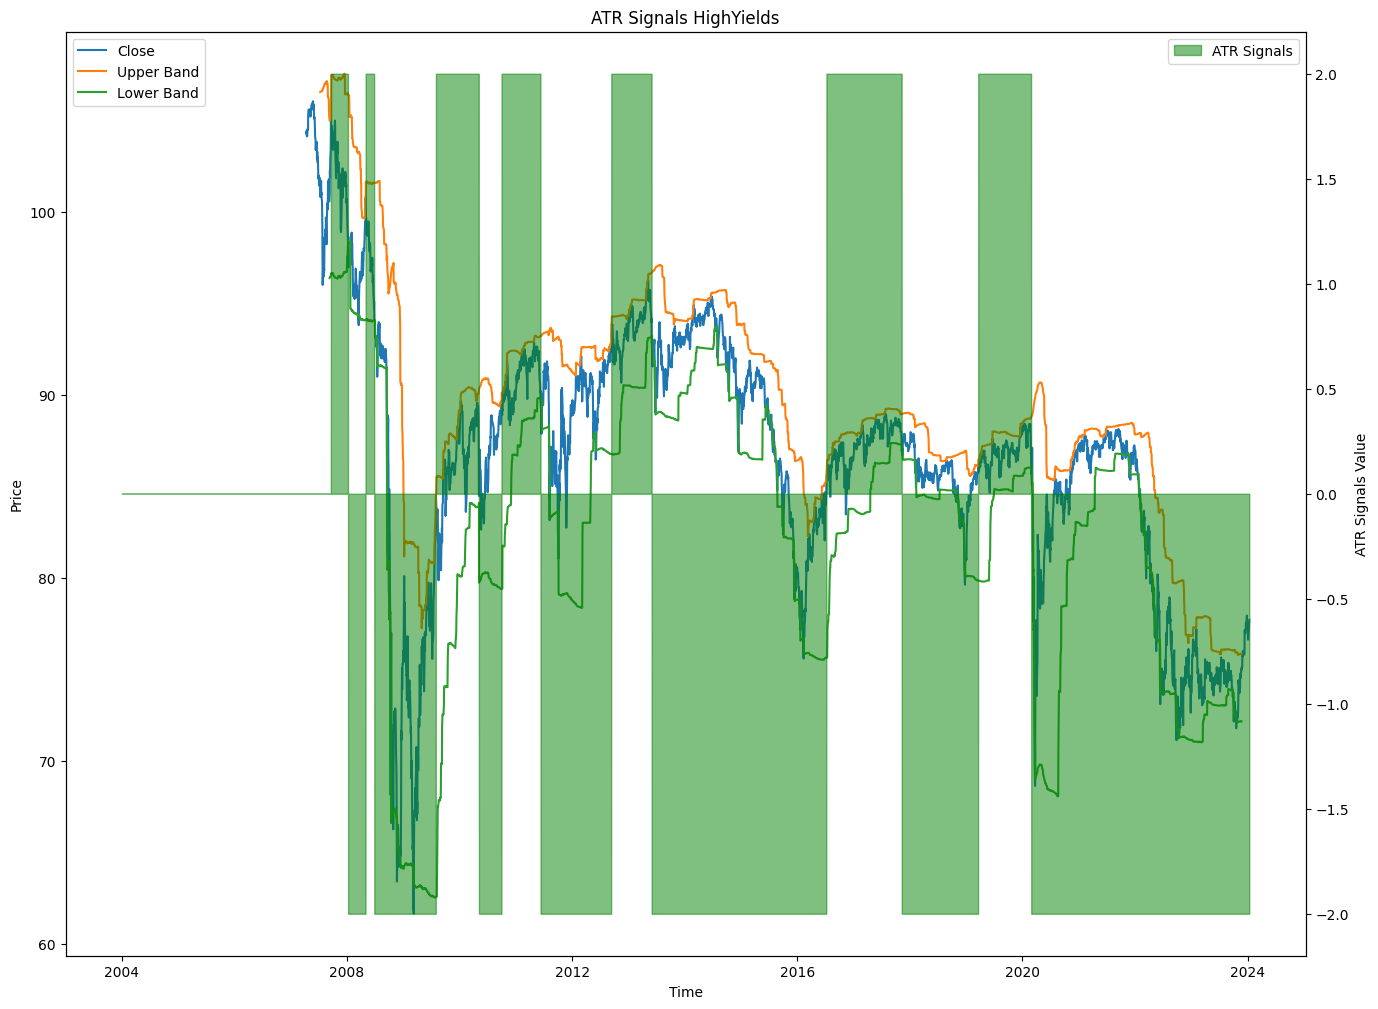

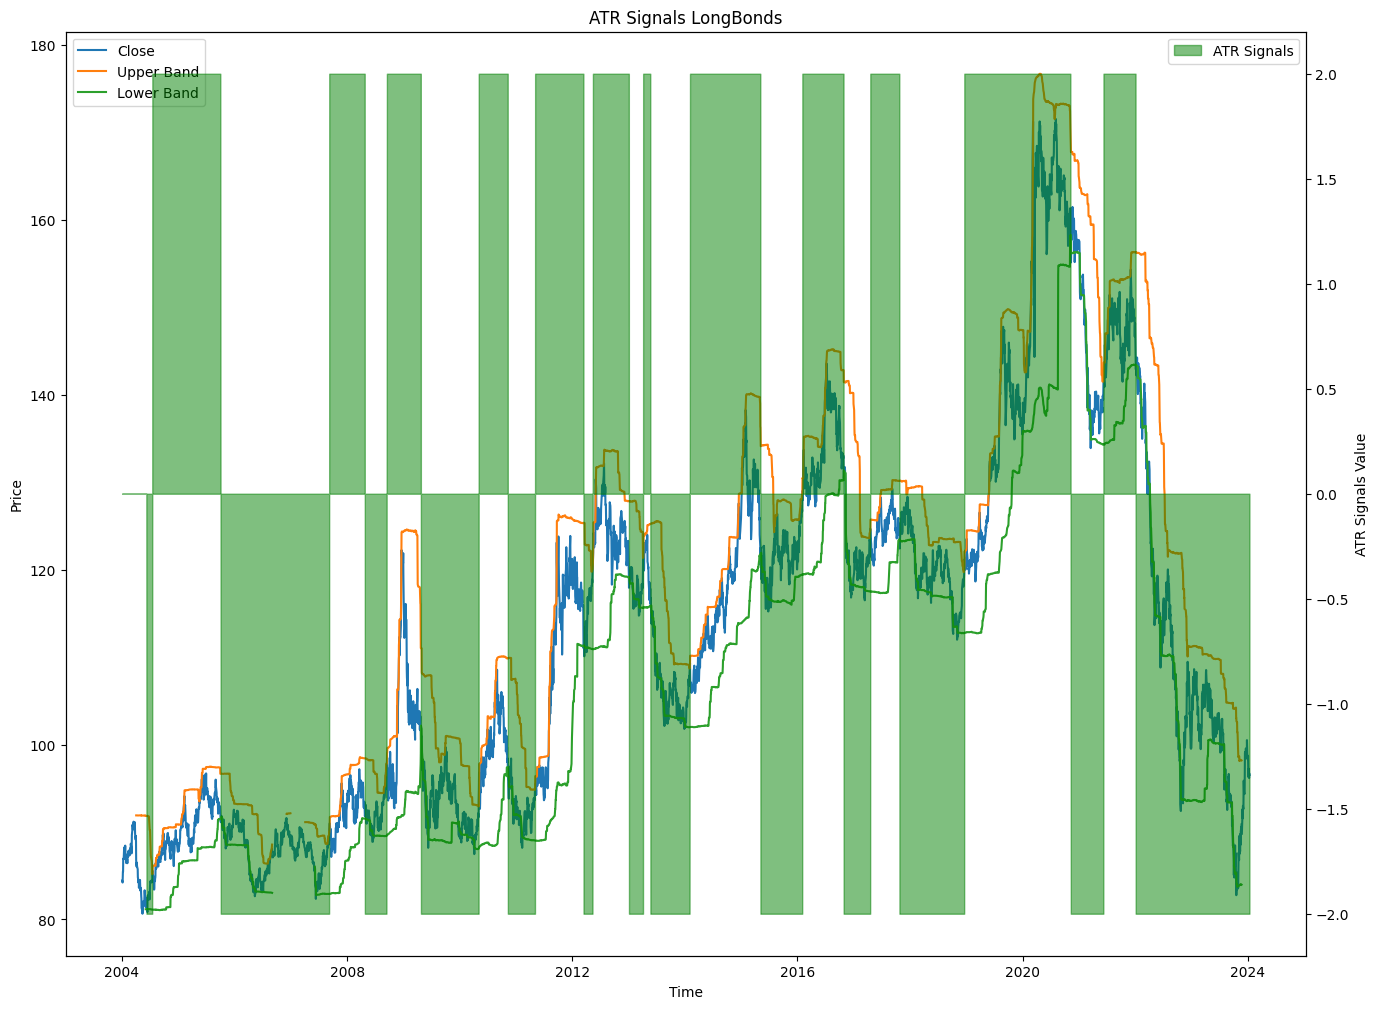

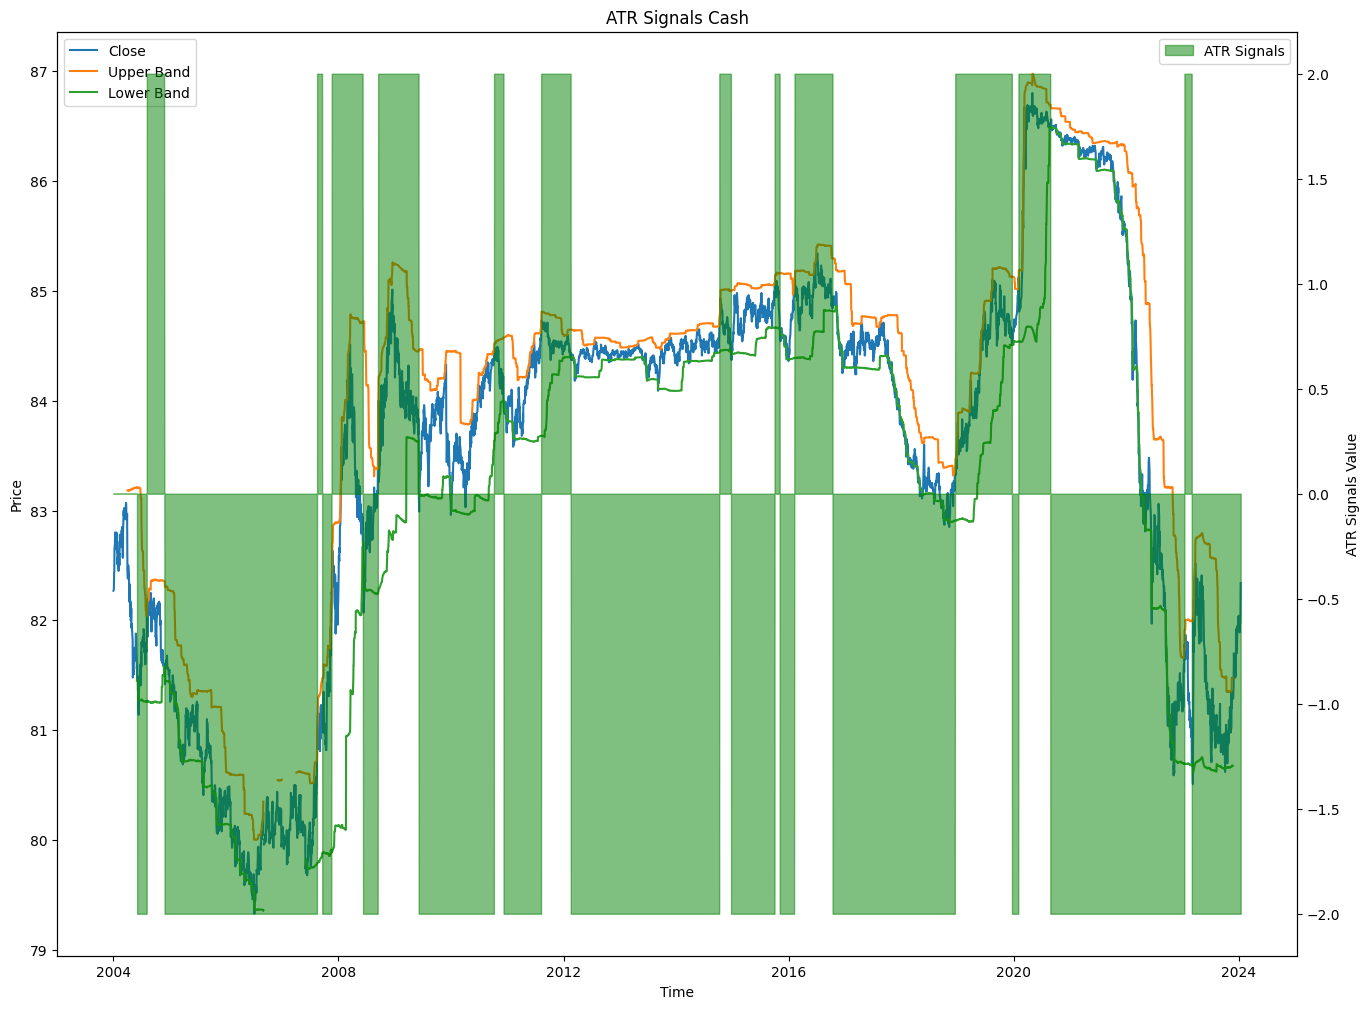

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('ATRSignals.pdf') as pdf:
    for ETF in ATRsignals.columns:
        fig, ax1 = plt.subplots(figsize=(16, 12))  # Create a new figure and set of axes for each ETF

        # Plotting 'Close', 'Upper_Band', and 'Lower_Band' on the primary y-axis
        ax1.plot(Close[ETF], label='Close')
        ax1.plot(Upper_Band[ETF], label='Upper Band')
        ax1.plot(Lower_Band[ETF], label='Lower Band')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title('ATR Signals ' + ETF)
        ax1.legend(loc='upper left')

        # Creating a second y-axis for the 'ATRsignals' series
        ax2 = ax1.twinx()
        ax2.fill_between(ATRsignals.index, ATRsignals[ETF], color='green', alpha=0.5, label='ATR Signals')
        ax2.set_ylabel('ATR Signals Value')
        ax2.legend(loc='upper right')

        # Save the current figure to PDF
        pdf.savefig(fig)


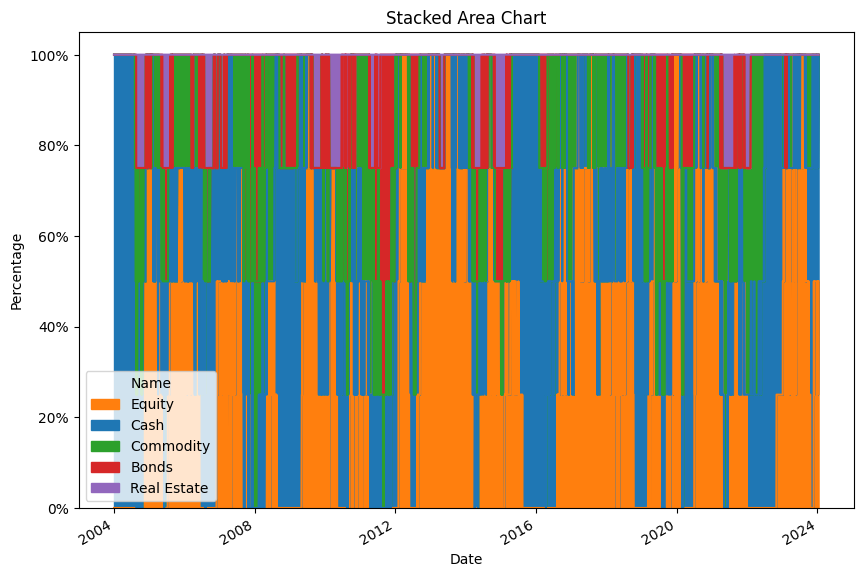

In [9]:
AANames=pd.DataFrame(listAssetClass,index=listNames,columns=['Name'])
WeightsAssetClass=AANames.merge(Weights.T,left_index=True,right_index=True).groupby('Name').sum().T

colors = ['#ff7f0e','#1f77b4',  '#2ca02c', '#d62728', '#9267bd']

ax = WeightsAssetClass[WeightsAssetClass.mean().sort_values(ascending=False).index].plot(kind='area', stacked=True, figsize=(10, 7),color=colors)

# Customizing the plot to improve readability
ax.set_ylabel('Percentage')
ax.set_xlabel('Date')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))  # Format y-axis as percentage
ax.set_title('Stacked Area Chart')

# Display the plot
plt.show()